# Assignment 4 - Generative Adversarial Networks (GANs)
## Part 1: Theory Questions

**Course:** DS552 - Generative AI  
**Instructor:** Narahara Chari Dingari, Ph.D.

---


### Q1: Explain the minimax loss function in GANs and how it ensures competitive training between the generator and discriminator.

**Minimax Loss Function:**

The GAN objective is a minimax game:
$$\min_G \max_D V(D, G) = \mathbb{E}_{x \sim p_{data}(x)}[\log D(x)] + \mathbb{E}_{z \sim p_z(z)}[\log(1 - D(G(z)))]$$

- The **discriminator** maximizes $V(D,G)$: it tries to correctly classify real samples (maximize $\log D(x)$) and reject fakes (maximize $\log(1-D(G(z)))$).
- The **generator** minimizes $V(D,G)$: it tries to make $D(G(z))$ large so that $\log(1-D(G(z)))$ is small, i.e., fool the discriminator.

**How It Ensures Competitive Training:**

1. **Adversarial objectives**: The generator and discriminator have opposing goals. The discriminator improves at distinguishing real vs fake, which forces the generator to produce more realistic samples to reduce its loss.
2. **Nash equilibrium**: Training alternates between updating D and G. At equilibrium, the generator matches the data distribution and the discriminator is at chance (0.5) everywhere.
3. **Gradient signal**: The discriminator’s output provides a learning signal for the generator; as D gets better, the generator must improve to keep fooling it, leading to a competitive co-evolution of both networks.


### Q2: What is mode collapse? Why can mode collapse occur during GAN training? How can it be mitigated?

**What is Mode Collapse?**

Mode collapse occurs when the generator produces limited diversity, mapping many different noise inputs to the same or very similar outputs. The generator may only capture a few modes of the data distribution (e.g., only one digit in MNIST) instead of the full diversity.

**Why It Occurs:**

1. **Discriminator overpowering**: If the discriminator becomes too strong, it rejects most generator outputs. The generator may then find a few “safe” outputs that consistently fool D and keep producing those.
2. **Optimization landscape**: The generator can get stuck in local minima where producing a narrow set of samples minimizes its loss.
3. **Poor gradient signal**: When D is very confident, gradients for the generator can vanish, so the generator stops exploring.
4. **Insufficient capacity or exploration**: The generator may not have enough capacity or may not explore the latent space well.

**Mitigation:**

- **Wasserstein GAN (WGAN)**: More stable gradients and better correlation with sample quality.
- **Unrolled GANs / gradient penalty**: Prevent the discriminator from becoming too strong too quickly.
- **Mini-batch discrimination**: Let the discriminator see multiple samples at once to detect lack of diversity.
- **Spectral normalization**: Limit the discriminator’s Lipschitz constant to stabilize training.
- **Label smoothing**: Use soft labels (e.g., 0.9 instead of 1.0 for real) to avoid overconfident D.
- **Two time-scale updates (TTUR)**: Use different learning rates for G and D to balance training.


### Q3: Explain the role of the discriminator in adversarial training.

**Role of the Discriminator:**

1. **Binary classifier**: The discriminator acts as a binary classifier that takes a sample (real or generated) and outputs a score or probability that the sample is real. It is trained to assign high scores to real data and low scores to generated data.

2. **Provider of learning signal**: The discriminator’s output is the only direct feedback the generator receives. The generator is trained to maximize the probability that its outputs are classified as real. So the discriminator’s gradients with respect to the generated samples drive the generator’s updates.

3. **Adversarial pressure**: By improving at distinguishing real from fake, the discriminator constantly raises the bar for the generator. This adversarial pressure pushes the generator to produce more realistic and diverse samples.

4. **Training dynamics**: Training alternates between updating the discriminator (on real vs fake batches) and the generator (to fool the discriminator). The discriminator must be strong enough to provide useful gradients but not so strong that the generator’s gradients vanish; balancing this is key to stable GAN training.


### Q4: How do metrics like IS and FID evaluate GAN performance?

**Inception Score (IS):**

- **Idea**: Use a pre-trained Inception network to measure the quality and diversity of generated images.
- **Computation**: Pass generated images through Inception; compute $\exp(\mathbb{E}[KL(p(y|x) \| p(y))])$, where $p(y|x)$ is the conditional class distribution for each image and $p(y)$ is the marginal.
- **Interpretation**: High conditional entropy $H(y|x)$ means each image is confidently classified (sharp, recognizable). High marginal entropy $H(y)$ means many classes are represented (diverse). So higher IS suggests both quality and diversity.
- **Limitation**: IS uses only generated images and does not compare to the real data distribution.

**Fréchet Inception Distance (FID):**

- **Idea**: Compare the distribution of real and generated images in the feature space of a pre-trained Inception network.
- **Computation**: Extract features for real and generated images; fit Gaussians $N(\mu_r, \Sigma_r)$ and $N(\mu_g, \Sigma_g)$; compute the Fréchet distance: $\|\mu_r - \mu_g\|^2 + Tr(\Sigma_r + \Sigma_g - 2(\Sigma_r \Sigma_g)^{1/2})$.
- **Interpretation**: Lower FID means the generated distribution is closer to the real distribution in feature space, i.e., better quality and diversity.
- **Advantage**: FID compares directly to the real data and is generally more reliable than IS. It is sensitive to mode collapse (low diversity increases FID).


# Assignment 4 - Generative Adversarial Networks (GANs)
## Part 2: Coding Assignment

**Course:** DS552 - Generative AI  
**Instructor:** Narahara Chari Dingari, Ph.D.

---

1. GAN on MNIST (convolutional generator, save images every 10 epochs).
2. Same GAN on CIFAR-10 with updated dimensions (32×32×3).
- **Extensions**: WGAN-GP and Conditional GAN are included as optional experiments.


## Task 1: GAN on MNIST

Convolutional generator and discriminator on MNIST. Binary cross-entropy loss. Save generated images every 10 epochs.


# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid
import os

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

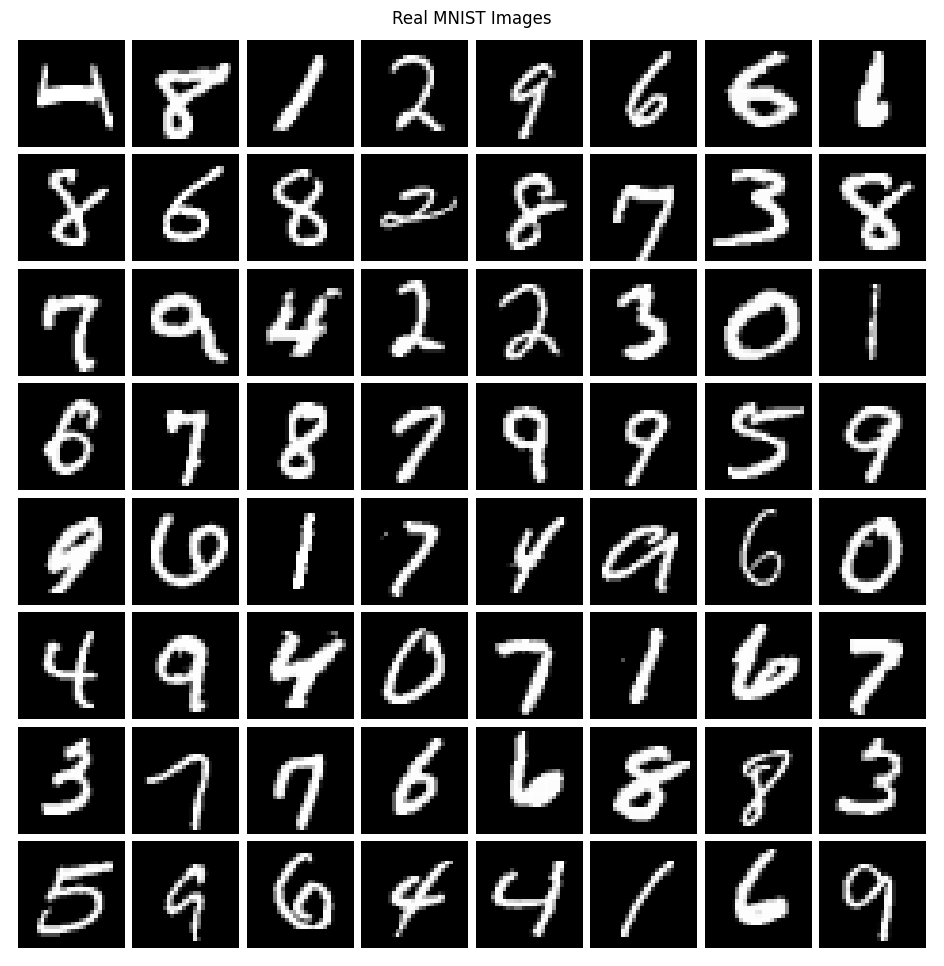

In [10]:
# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
val_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)

# Visualize some real images
def show_images(images, title="Images", nrow=8):
    """Helper function to display images"""
    images = images.cpu()
    grid = make_grid(images, nrow=nrow, normalize=True, pad_value=1)
    plt.figure(figsize=(12, 12))
    plt.imshow(grid.permute(1, 2, 0))
    plt.title(title)
    plt.axis('off')
    plt.show()

# Show sample real images
real_images, _ = next(iter(train_loader))
show_images(real_images[:64], "Real MNIST Images")

In [11]:
# Define Generator Network (with convolutional layers, as in assignment PDF)
class Generator(nn.Module):
    def __init__(self, latent_dim=100, img_size=28, n_channels=1):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        self.img_size = img_size
        # Dense -> Reshape to 7x7x256, then ConvTranspose layers (matches PDF architecture)
        self.fc = nn.Linear(latent_dim, 7 * 7 * 256)
        self.model = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 5, stride=1, padding=2, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(128, 64, 5, stride=2, padding=2, output_padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(64, n_channels, 5, stride=2, padding=2, output_padding=1, bias=False),
            nn.Tanh()
        )
    
    def forward(self, z):
        x = self.fc(z)
        x = x.view(-1, 256, 7, 7)
        img = self.model(x)
        return img

# Define Discriminator Network (convolutional, as in assignment PDF)
class Discriminator(nn.Module):
    def __init__(self, img_size=28, n_channels=1):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(n_channels, 64, 5, stride=2, padding=2),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Conv2d(64, 128, 5, stride=2, padding=2),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Flatten(),
            nn.Linear(128 * 7 * 7, 1),
            nn.Sigmoid()
        )
    
    def forward(self, img):
        return self.model(img)

# Initialize networks
latent_dim = 100
generator = Generator(latent_dim=latent_dim).to(device)
discriminator = Discriminator().to(device)

# Print model architectures
print("Generator:")
print(generator)
print("\nDiscriminator:")
print(discriminator)

# Count parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nGenerator parameters: {count_parameters(generator):,}")
print(f"Discriminator parameters: {count_parameters(discriminator):,}")

Generator:
Generator(
  (fc): Linear(in_features=100, out_features=12544, bias=True)
  (model): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): ConvTranspose2d(64, 1, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1), bias=False)
    (7): Tanh()
  )
)

Discriminator:
Discriminator(
  (model): Sequential(
    (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2,

In [12]:
# Loss function and optimizers
adversarial_loss = nn.BCELoss()

# Optimizers
lr = 0.0002
beta1 = 0.5
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

# Training parameters
n_epochs = 100
print_every = 100
save_every = 10

# Create directory for saving generated images
os.makedirs('generated_images/basic_gan', exist_ok=True)

# Training history
G_losses = []
D_losses = []

Starting training...
[Epoch 0/100] [Batch 0/938] [D loss: 0.6822] [G loss: 0.6935]
[Epoch 0/100] [Batch 100/938] [D loss: 0.6054] [G loss: 1.0467]
[Epoch 0/100] [Batch 200/938] [D loss: 0.6177] [G loss: 0.9222]
[Epoch 0/100] [Batch 300/938] [D loss: 0.6592] [G loss: 1.0575]
[Epoch 0/100] [Batch 400/938] [D loss: 0.7148] [G loss: 1.0454]
[Epoch 0/100] [Batch 500/938] [D loss: 0.6670] [G loss: 0.8263]
[Epoch 0/100] [Batch 600/938] [D loss: 0.6197] [G loss: 0.8050]
[Epoch 0/100] [Batch 700/938] [D loss: 0.6365] [G loss: 1.0650]
[Epoch 0/100] [Batch 800/938] [D loss: 0.5978] [G loss: 0.9729]
[Epoch 0/100] [Batch 900/938] [D loss: 0.5662] [G loss: 0.9901]


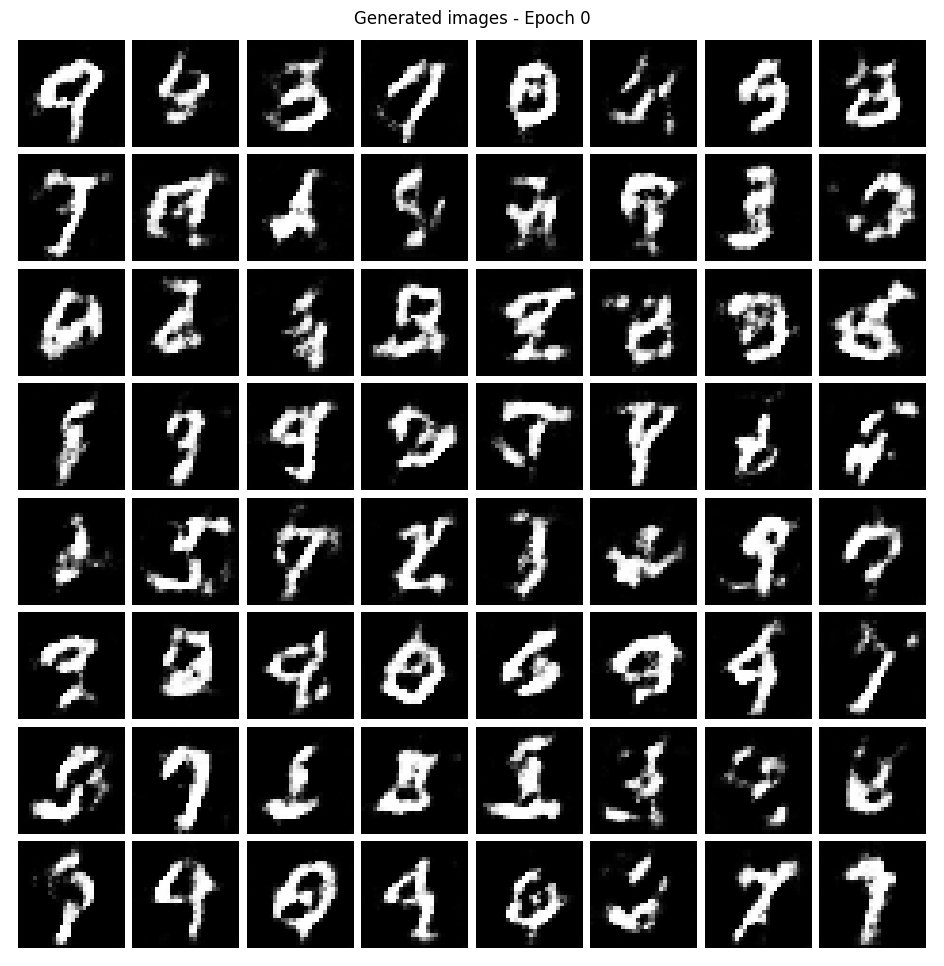

[Epoch 1/100] [Batch 0/938] [D loss: 0.6183] [G loss: 1.1563]
[Epoch 1/100] [Batch 100/938] [D loss: 0.6111] [G loss: 1.3058]
[Epoch 1/100] [Batch 200/938] [D loss: 0.5394] [G loss: 0.9678]
[Epoch 1/100] [Batch 300/938] [D loss: 0.6227] [G loss: 1.0462]
[Epoch 1/100] [Batch 400/938] [D loss: 0.6444] [G loss: 1.0603]
[Epoch 1/100] [Batch 500/938] [D loss: 0.6206] [G loss: 1.1280]
[Epoch 1/100] [Batch 600/938] [D loss: 0.6411] [G loss: 0.8728]
[Epoch 1/100] [Batch 700/938] [D loss: 0.5997] [G loss: 0.7822]
[Epoch 1/100] [Batch 800/938] [D loss: 0.6473] [G loss: 1.0088]
[Epoch 1/100] [Batch 900/938] [D loss: 0.6204] [G loss: 0.6878]
[Epoch 2/100] [Batch 0/938] [D loss: 0.6617] [G loss: 0.6267]
[Epoch 2/100] [Batch 100/938] [D loss: 0.6736] [G loss: 0.8504]
[Epoch 2/100] [Batch 200/938] [D loss: 0.6539] [G loss: 0.7844]
[Epoch 2/100] [Batch 300/938] [D loss: 0.6526] [G loss: 0.8752]
[Epoch 2/100] [Batch 400/938] [D loss: 0.6447] [G loss: 0.7890]
[Epoch 2/100] [Batch 500/938] [D loss: 0.715

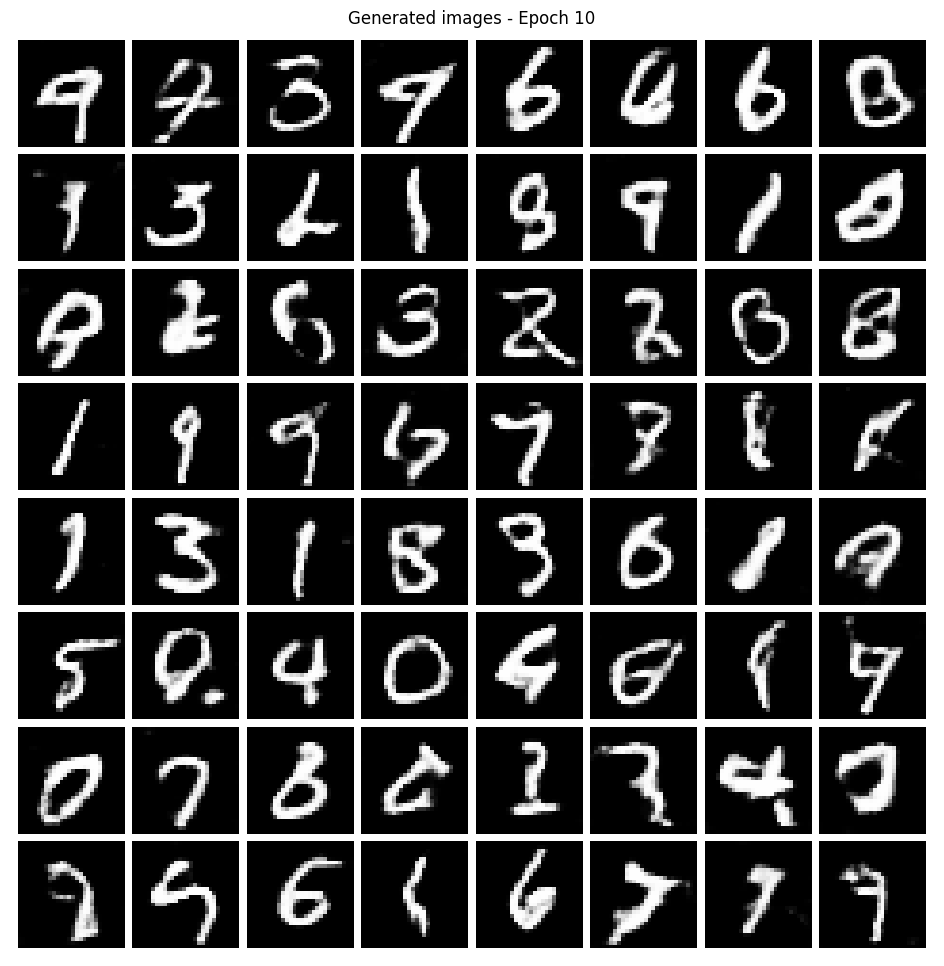

[Epoch 11/100] [Batch 0/938] [D loss: 0.6121] [G loss: 0.8614]
[Epoch 11/100] [Batch 100/938] [D loss: 0.6211] [G loss: 0.8543]
[Epoch 11/100] [Batch 200/938] [D loss: 0.6403] [G loss: 0.9175]
[Epoch 11/100] [Batch 300/938] [D loss: 0.6261] [G loss: 0.7873]
[Epoch 11/100] [Batch 400/938] [D loss: 0.6154] [G loss: 1.0413]
[Epoch 11/100] [Batch 500/938] [D loss: 0.5957] [G loss: 0.7992]
[Epoch 11/100] [Batch 600/938] [D loss: 0.6816] [G loss: 0.8799]
[Epoch 11/100] [Batch 700/938] [D loss: 0.6307] [G loss: 0.9768]
[Epoch 11/100] [Batch 800/938] [D loss: 0.6157] [G loss: 0.8930]
[Epoch 11/100] [Batch 900/938] [D loss: 0.5836] [G loss: 0.9852]
[Epoch 12/100] [Batch 0/938] [D loss: 0.6321] [G loss: 1.0122]
[Epoch 12/100] [Batch 100/938] [D loss: 0.6452] [G loss: 0.9287]
[Epoch 12/100] [Batch 200/938] [D loss: 0.6154] [G loss: 0.9438]
[Epoch 12/100] [Batch 300/938] [D loss: 0.5774] [G loss: 0.9664]
[Epoch 12/100] [Batch 400/938] [D loss: 0.6264] [G loss: 0.9370]
[Epoch 12/100] [Batch 500/938

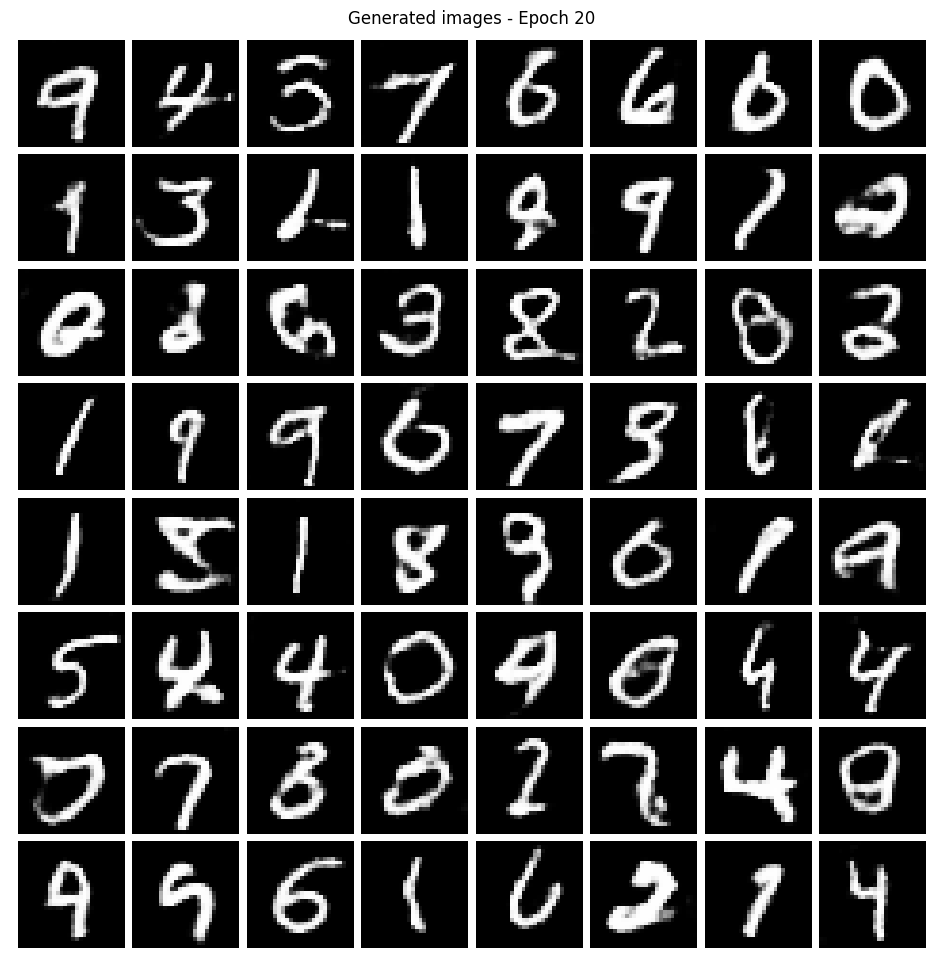

[Epoch 21/100] [Batch 0/938] [D loss: 0.6162] [G loss: 1.0482]
[Epoch 21/100] [Batch 100/938] [D loss: 0.6569] [G loss: 1.0306]
[Epoch 21/100] [Batch 200/938] [D loss: 0.6126] [G loss: 0.9442]
[Epoch 21/100] [Batch 300/938] [D loss: 0.5849] [G loss: 1.0087]
[Epoch 21/100] [Batch 400/938] [D loss: 0.6499] [G loss: 0.8876]
[Epoch 21/100] [Batch 500/938] [D loss: 0.6544] [G loss: 1.0199]
[Epoch 21/100] [Batch 600/938] [D loss: 0.5599] [G loss: 0.8303]
[Epoch 21/100] [Batch 700/938] [D loss: 0.6503] [G loss: 0.9353]
[Epoch 21/100] [Batch 800/938] [D loss: 0.6477] [G loss: 0.9053]
[Epoch 21/100] [Batch 900/938] [D loss: 0.6466] [G loss: 0.8373]
[Epoch 22/100] [Batch 0/938] [D loss: 0.6547] [G loss: 1.0643]
[Epoch 22/100] [Batch 100/938] [D loss: 0.6429] [G loss: 0.9710]
[Epoch 22/100] [Batch 200/938] [D loss: 0.6086] [G loss: 0.8415]
[Epoch 22/100] [Batch 300/938] [D loss: 0.6654] [G loss: 0.8064]
[Epoch 22/100] [Batch 400/938] [D loss: 0.6119] [G loss: 0.8756]
[Epoch 22/100] [Batch 500/938

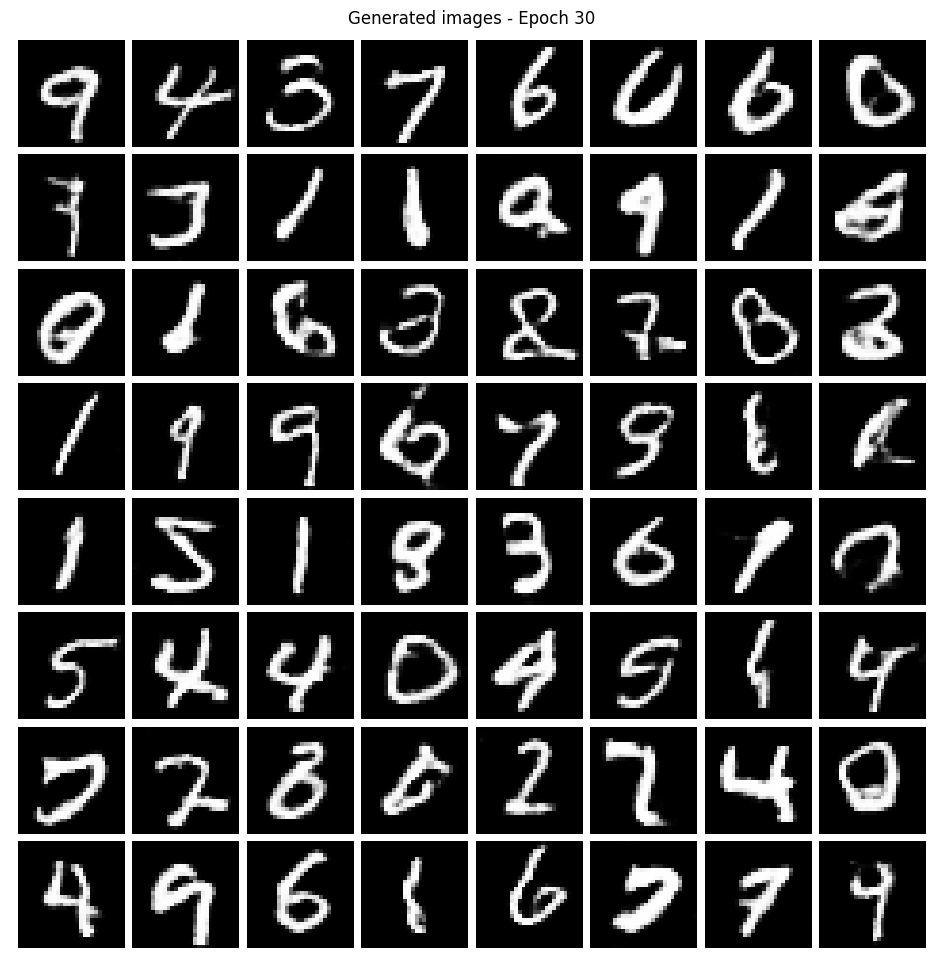

[Epoch 31/100] [Batch 0/938] [D loss: 0.5432] [G loss: 0.9466]
[Epoch 31/100] [Batch 100/938] [D loss: 0.5718] [G loss: 0.8631]
[Epoch 31/100] [Batch 200/938] [D loss: 0.5873] [G loss: 0.8612]
[Epoch 31/100] [Batch 300/938] [D loss: 0.6364] [G loss: 0.9933]
[Epoch 31/100] [Batch 400/938] [D loss: 0.6782] [G loss: 0.9590]
[Epoch 31/100] [Batch 500/938] [D loss: 0.6119] [G loss: 0.9118]
[Epoch 31/100] [Batch 600/938] [D loss: 0.6060] [G loss: 1.1485]
[Epoch 31/100] [Batch 700/938] [D loss: 0.5982] [G loss: 0.9117]
[Epoch 31/100] [Batch 800/938] [D loss: 0.5515] [G loss: 0.9660]
[Epoch 31/100] [Batch 900/938] [D loss: 0.6600] [G loss: 1.0032]
[Epoch 32/100] [Batch 0/938] [D loss: 0.6057] [G loss: 0.9520]
[Epoch 32/100] [Batch 100/938] [D loss: 0.6604] [G loss: 1.0258]
[Epoch 32/100] [Batch 200/938] [D loss: 0.5852] [G loss: 0.8291]
[Epoch 32/100] [Batch 300/938] [D loss: 0.6764] [G loss: 0.8497]
[Epoch 32/100] [Batch 400/938] [D loss: 0.6109] [G loss: 0.8943]
[Epoch 32/100] [Batch 500/938

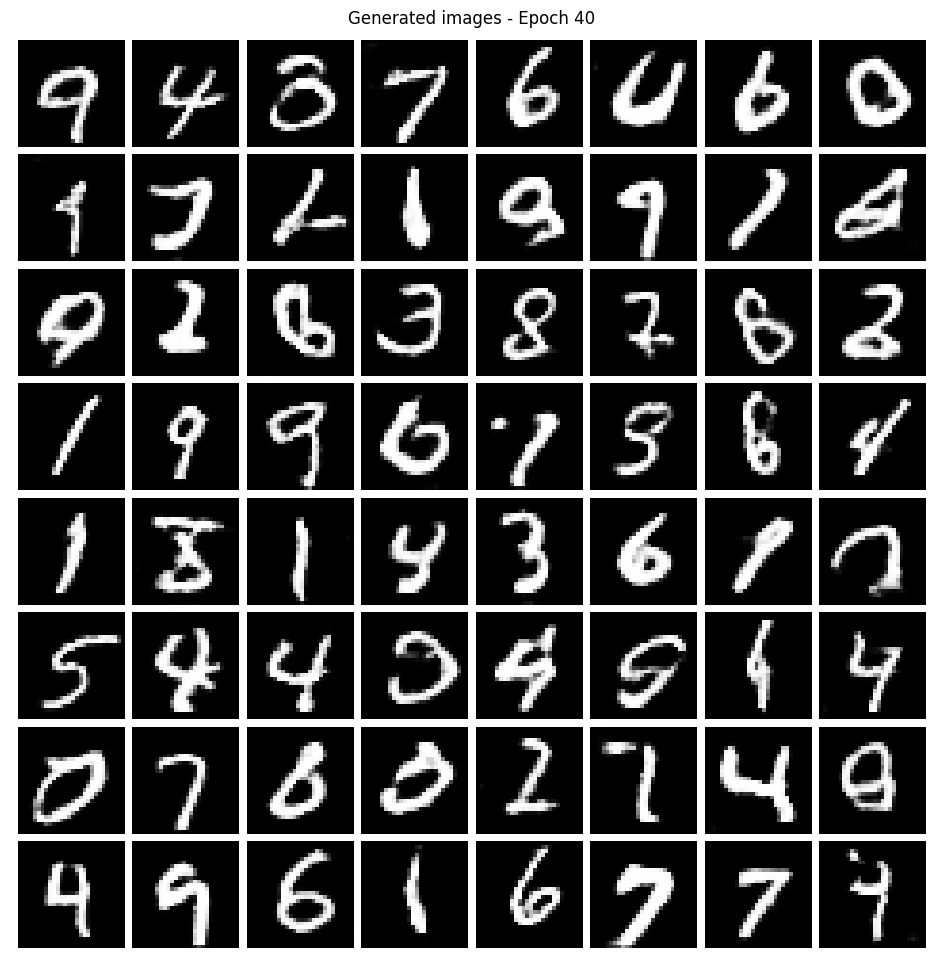

[Epoch 41/100] [Batch 0/938] [D loss: 0.6547] [G loss: 0.9418]
[Epoch 41/100] [Batch 100/938] [D loss: 0.6307] [G loss: 1.0818]
[Epoch 41/100] [Batch 200/938] [D loss: 0.5825] [G loss: 1.0258]
[Epoch 41/100] [Batch 300/938] [D loss: 0.6445] [G loss: 0.7574]
[Epoch 41/100] [Batch 400/938] [D loss: 0.6380] [G loss: 1.0450]
[Epoch 41/100] [Batch 500/938] [D loss: 0.6056] [G loss: 0.9167]
[Epoch 41/100] [Batch 600/938] [D loss: 0.5610] [G loss: 1.0233]
[Epoch 41/100] [Batch 700/938] [D loss: 0.5977] [G loss: 1.0732]
[Epoch 41/100] [Batch 800/938] [D loss: 0.6312] [G loss: 1.1439]
[Epoch 41/100] [Batch 900/938] [D loss: 0.5731] [G loss: 0.9994]
[Epoch 42/100] [Batch 0/938] [D loss: 0.5586] [G loss: 0.9527]
[Epoch 42/100] [Batch 100/938] [D loss: 0.6553] [G loss: 0.8935]
[Epoch 42/100] [Batch 200/938] [D loss: 0.6455] [G loss: 0.8510]
[Epoch 42/100] [Batch 300/938] [D loss: 0.5865] [G loss: 1.1024]
[Epoch 42/100] [Batch 400/938] [D loss: 0.6671] [G loss: 0.8588]
[Epoch 42/100] [Batch 500/938

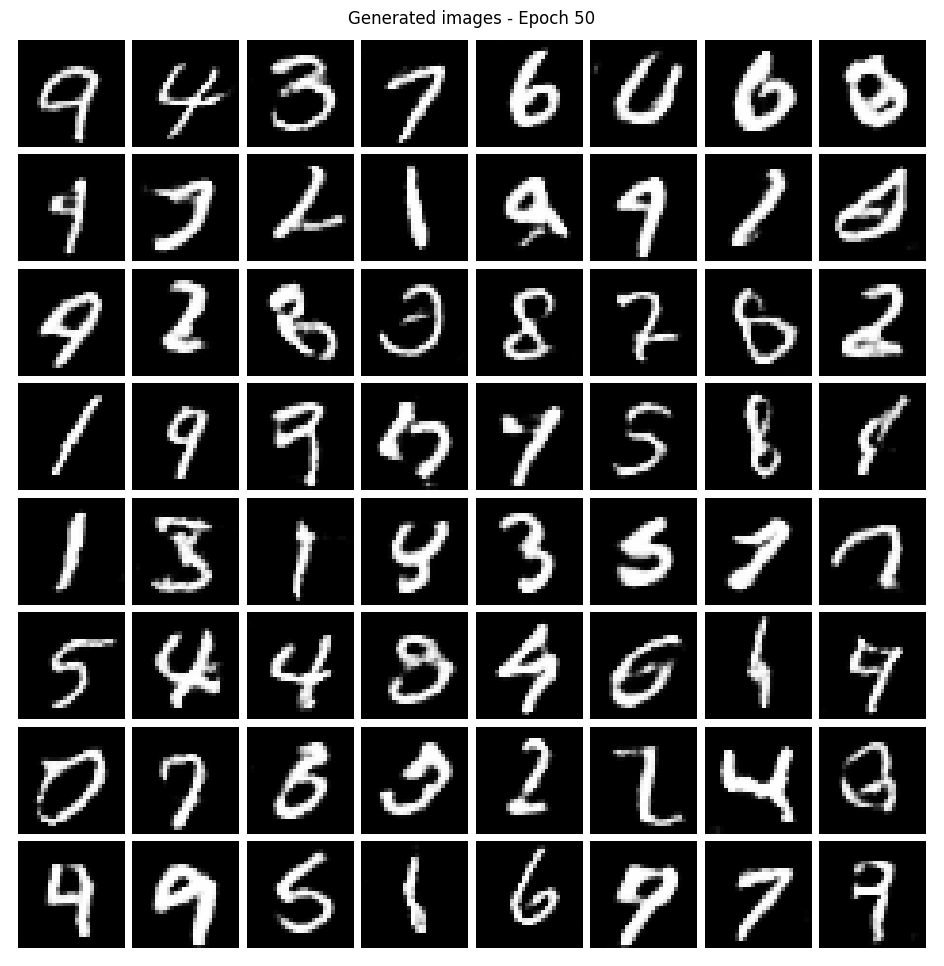

[Epoch 51/100] [Batch 0/938] [D loss: 0.6752] [G loss: 0.9338]
[Epoch 51/100] [Batch 100/938] [D loss: 0.5624] [G loss: 0.9510]
[Epoch 51/100] [Batch 200/938] [D loss: 0.6011] [G loss: 0.7516]
[Epoch 51/100] [Batch 300/938] [D loss: 0.5763] [G loss: 1.0315]
[Epoch 51/100] [Batch 400/938] [D loss: 0.5857] [G loss: 0.9817]
[Epoch 51/100] [Batch 500/938] [D loss: 0.5933] [G loss: 1.0404]
[Epoch 51/100] [Batch 600/938] [D loss: 0.6163] [G loss: 0.8863]
[Epoch 51/100] [Batch 700/938] [D loss: 0.5922] [G loss: 1.0880]
[Epoch 51/100] [Batch 800/938] [D loss: 0.6183] [G loss: 1.1489]
[Epoch 51/100] [Batch 900/938] [D loss: 0.6073] [G loss: 0.8009]
[Epoch 52/100] [Batch 0/938] [D loss: 0.5734] [G loss: 1.0546]
[Epoch 52/100] [Batch 100/938] [D loss: 0.5935] [G loss: 1.0592]
[Epoch 52/100] [Batch 200/938] [D loss: 0.6160] [G loss: 1.0729]
[Epoch 52/100] [Batch 300/938] [D loss: 0.5815] [G loss: 1.0675]
[Epoch 52/100] [Batch 400/938] [D loss: 0.6411] [G loss: 1.1068]
[Epoch 52/100] [Batch 500/938

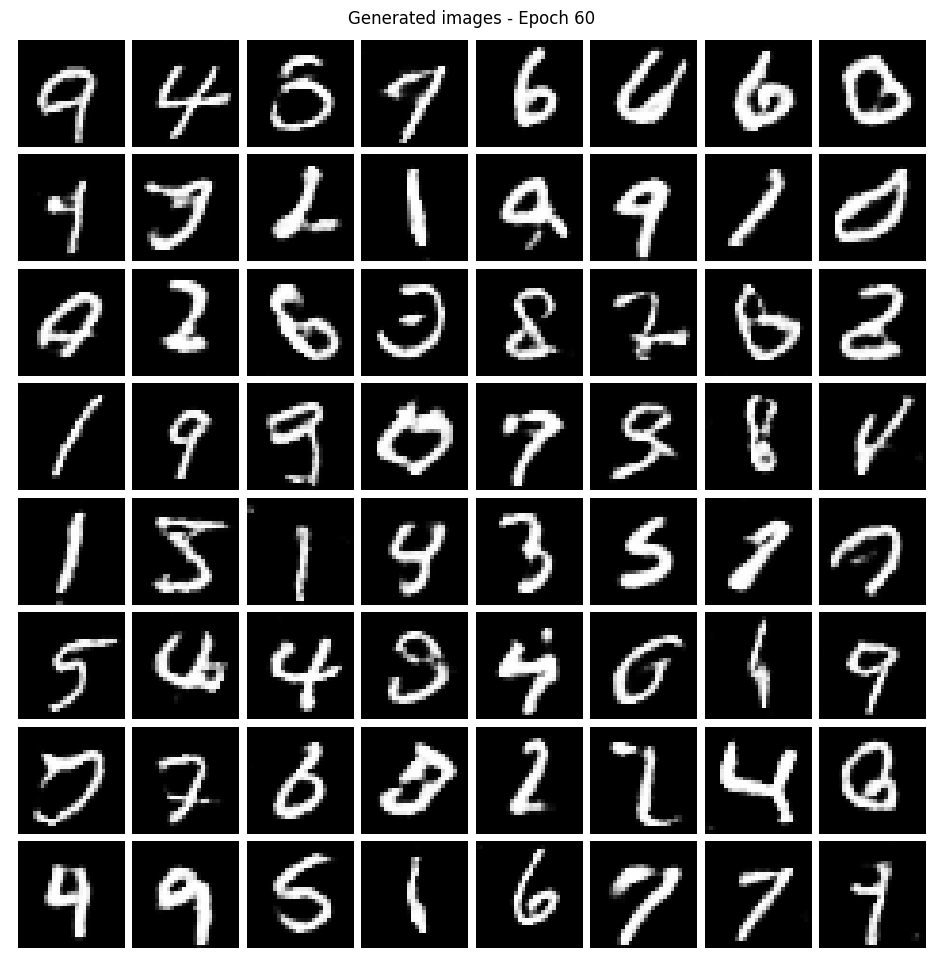

[Epoch 61/100] [Batch 0/938] [D loss: 0.5987] [G loss: 0.8828]
[Epoch 61/100] [Batch 100/938] [D loss: 0.5860] [G loss: 1.2547]
[Epoch 61/100] [Batch 200/938] [D loss: 0.5809] [G loss: 0.9514]
[Epoch 61/100] [Batch 300/938] [D loss: 0.6303] [G loss: 1.0192]
[Epoch 61/100] [Batch 400/938] [D loss: 0.5968] [G loss: 0.9860]
[Epoch 61/100] [Batch 500/938] [D loss: 0.5677] [G loss: 0.9742]
[Epoch 61/100] [Batch 600/938] [D loss: 0.6940] [G loss: 0.9600]
[Epoch 61/100] [Batch 700/938] [D loss: 0.5855] [G loss: 1.0969]
[Epoch 61/100] [Batch 800/938] [D loss: 0.5706] [G loss: 0.8728]
[Epoch 61/100] [Batch 900/938] [D loss: 0.5978] [G loss: 0.7879]
[Epoch 62/100] [Batch 0/938] [D loss: 0.5666] [G loss: 1.0858]
[Epoch 62/100] [Batch 100/938] [D loss: 0.6103] [G loss: 1.0533]
[Epoch 62/100] [Batch 200/938] [D loss: 0.5847] [G loss: 1.1478]
[Epoch 62/100] [Batch 300/938] [D loss: 0.5846] [G loss: 0.7230]
[Epoch 62/100] [Batch 400/938] [D loss: 0.5493] [G loss: 1.0621]
[Epoch 62/100] [Batch 500/938

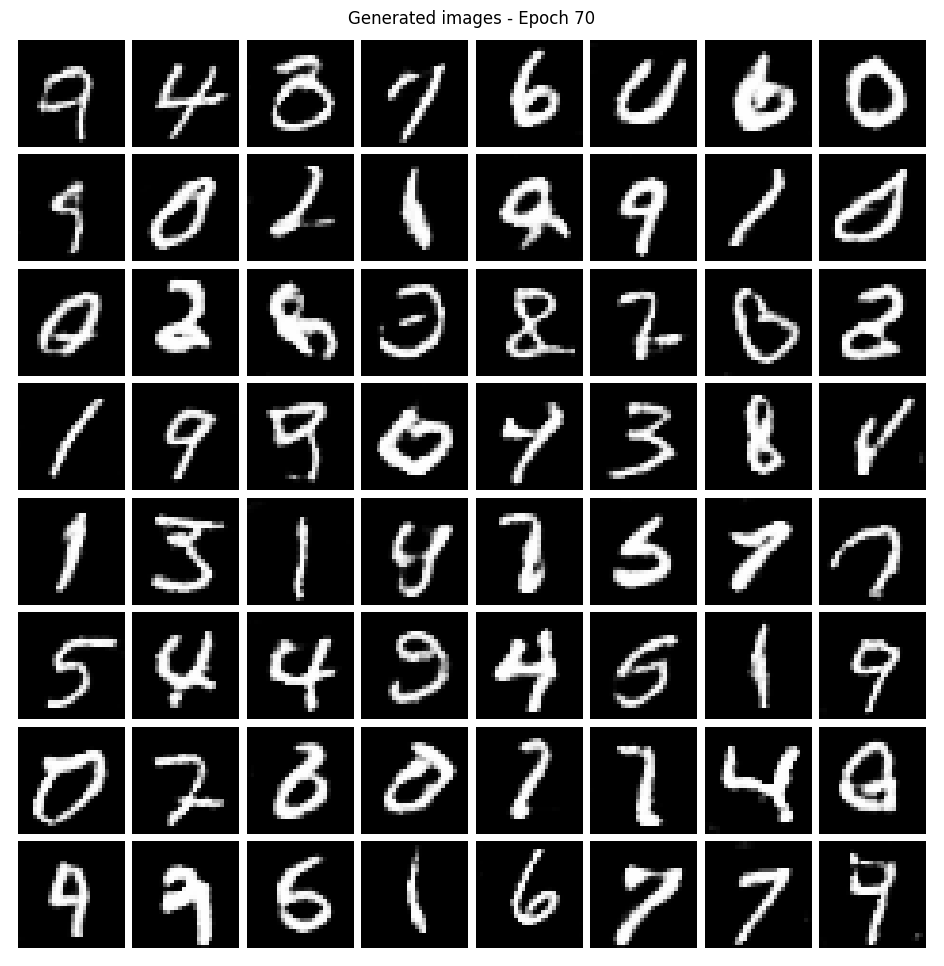

[Epoch 71/100] [Batch 0/938] [D loss: 0.6013] [G loss: 1.0686]
[Epoch 71/100] [Batch 100/938] [D loss: 0.6092] [G loss: 1.1698]
[Epoch 71/100] [Batch 200/938] [D loss: 0.5930] [G loss: 1.1520]
[Epoch 71/100] [Batch 300/938] [D loss: 0.5740] [G loss: 0.9639]
[Epoch 71/100] [Batch 400/938] [D loss: 0.5649] [G loss: 0.9744]
[Epoch 71/100] [Batch 500/938] [D loss: 0.6383] [G loss: 1.2595]
[Epoch 71/100] [Batch 600/938] [D loss: 0.5877] [G loss: 0.9230]
[Epoch 71/100] [Batch 700/938] [D loss: 0.5979] [G loss: 0.8203]
[Epoch 71/100] [Batch 800/938] [D loss: 0.5410] [G loss: 0.9483]
[Epoch 71/100] [Batch 900/938] [D loss: 0.6060] [G loss: 1.1266]
[Epoch 72/100] [Batch 0/938] [D loss: 0.5761] [G loss: 0.9241]
[Epoch 72/100] [Batch 100/938] [D loss: 0.5759] [G loss: 1.0137]
[Epoch 72/100] [Batch 200/938] [D loss: 0.5767] [G loss: 1.0752]
[Epoch 72/100] [Batch 300/938] [D loss: 0.6326] [G loss: 0.9557]
[Epoch 72/100] [Batch 400/938] [D loss: 0.5903] [G loss: 1.2526]
[Epoch 72/100] [Batch 500/938

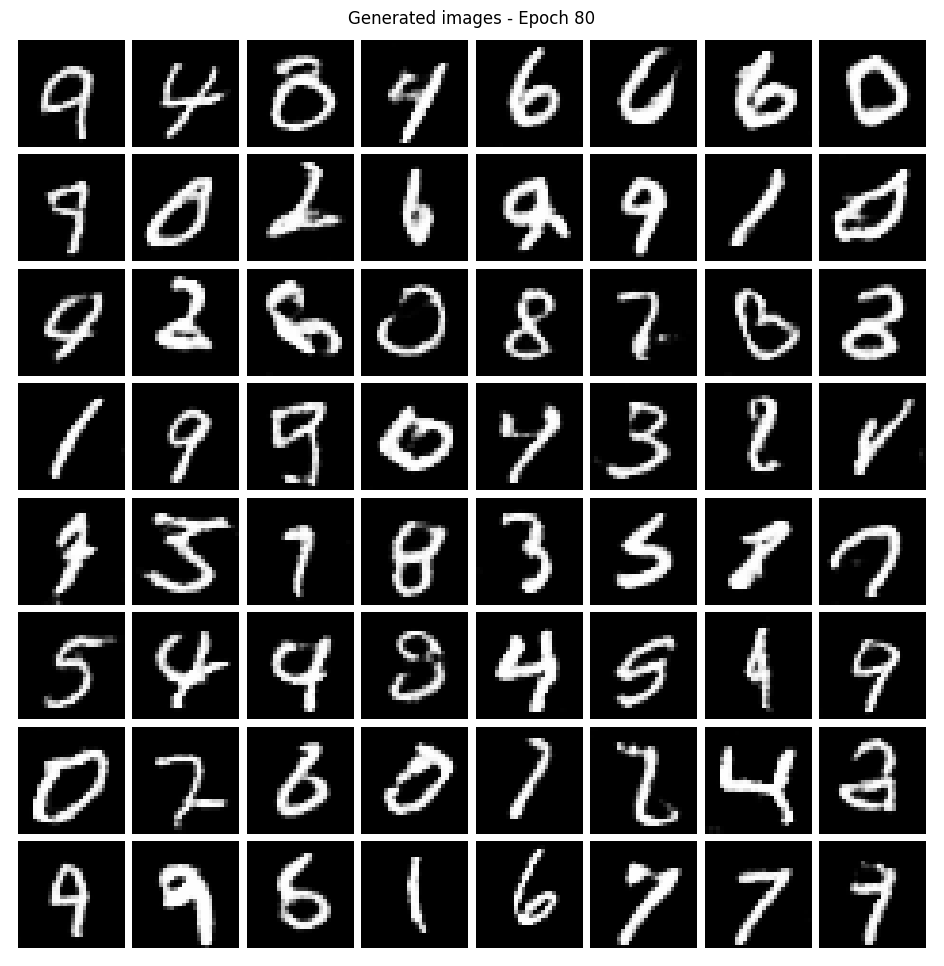

[Epoch 81/100] [Batch 0/938] [D loss: 0.5715] [G loss: 1.0576]
[Epoch 81/100] [Batch 100/938] [D loss: 0.5996] [G loss: 0.8895]
[Epoch 81/100] [Batch 200/938] [D loss: 0.5949] [G loss: 1.0651]
[Epoch 81/100] [Batch 300/938] [D loss: 0.5505] [G loss: 1.2006]
[Epoch 81/100] [Batch 400/938] [D loss: 0.6278] [G loss: 1.1377]
[Epoch 81/100] [Batch 500/938] [D loss: 0.5764] [G loss: 1.0892]
[Epoch 81/100] [Batch 600/938] [D loss: 0.6172] [G loss: 0.9076]
[Epoch 81/100] [Batch 700/938] [D loss: 0.6358] [G loss: 1.0833]
[Epoch 81/100] [Batch 800/938] [D loss: 0.6381] [G loss: 1.1933]
[Epoch 81/100] [Batch 900/938] [D loss: 0.5593] [G loss: 1.0829]
[Epoch 82/100] [Batch 0/938] [D loss: 0.6137] [G loss: 0.8210]
[Epoch 82/100] [Batch 100/938] [D loss: 0.5741] [G loss: 1.1173]
[Epoch 82/100] [Batch 200/938] [D loss: 0.5366] [G loss: 1.2747]
[Epoch 82/100] [Batch 300/938] [D loss: 0.6149] [G loss: 0.8959]
[Epoch 82/100] [Batch 400/938] [D loss: 0.6406] [G loss: 0.9473]
[Epoch 82/100] [Batch 500/938

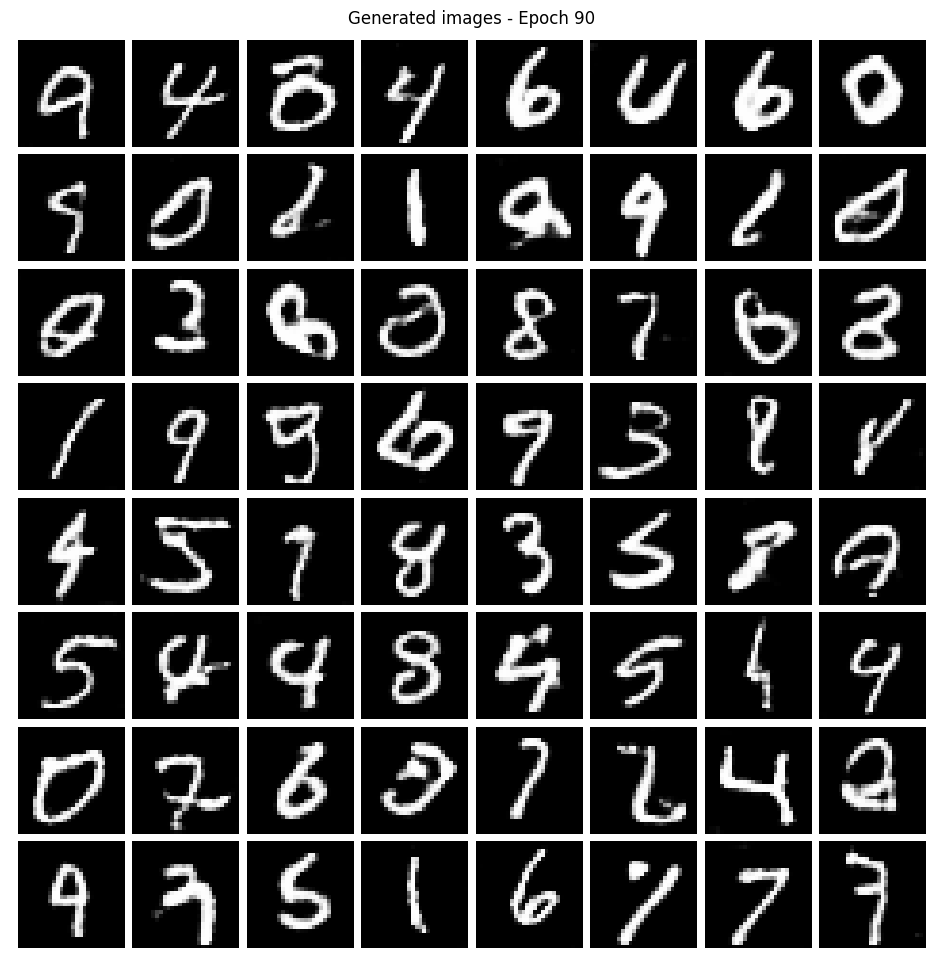

[Epoch 91/100] [Batch 0/938] [D loss: 0.5517] [G loss: 1.0700]
[Epoch 91/100] [Batch 100/938] [D loss: 0.6321] [G loss: 1.0199]
[Epoch 91/100] [Batch 200/938] [D loss: 0.5285] [G loss: 0.9324]
[Epoch 91/100] [Batch 300/938] [D loss: 0.5981] [G loss: 1.0933]
[Epoch 91/100] [Batch 400/938] [D loss: 0.5734] [G loss: 1.2273]
[Epoch 91/100] [Batch 500/938] [D loss: 0.6449] [G loss: 1.1208]
[Epoch 91/100] [Batch 600/938] [D loss: 0.6145] [G loss: 1.0006]
[Epoch 91/100] [Batch 700/938] [D loss: 0.5616] [G loss: 1.1159]
[Epoch 91/100] [Batch 800/938] [D loss: 0.5885] [G loss: 0.9019]
[Epoch 91/100] [Batch 900/938] [D loss: 0.5461] [G loss: 1.0073]
[Epoch 92/100] [Batch 0/938] [D loss: 0.6144] [G loss: 1.0326]
[Epoch 92/100] [Batch 100/938] [D loss: 0.6030] [G loss: 0.8438]
[Epoch 92/100] [Batch 200/938] [D loss: 0.5564] [G loss: 1.1777]
[Epoch 92/100] [Batch 300/938] [D loss: 0.6085] [G loss: 0.8741]
[Epoch 92/100] [Batch 400/938] [D loss: 0.5952] [G loss: 0.7473]
[Epoch 92/100] [Batch 500/938

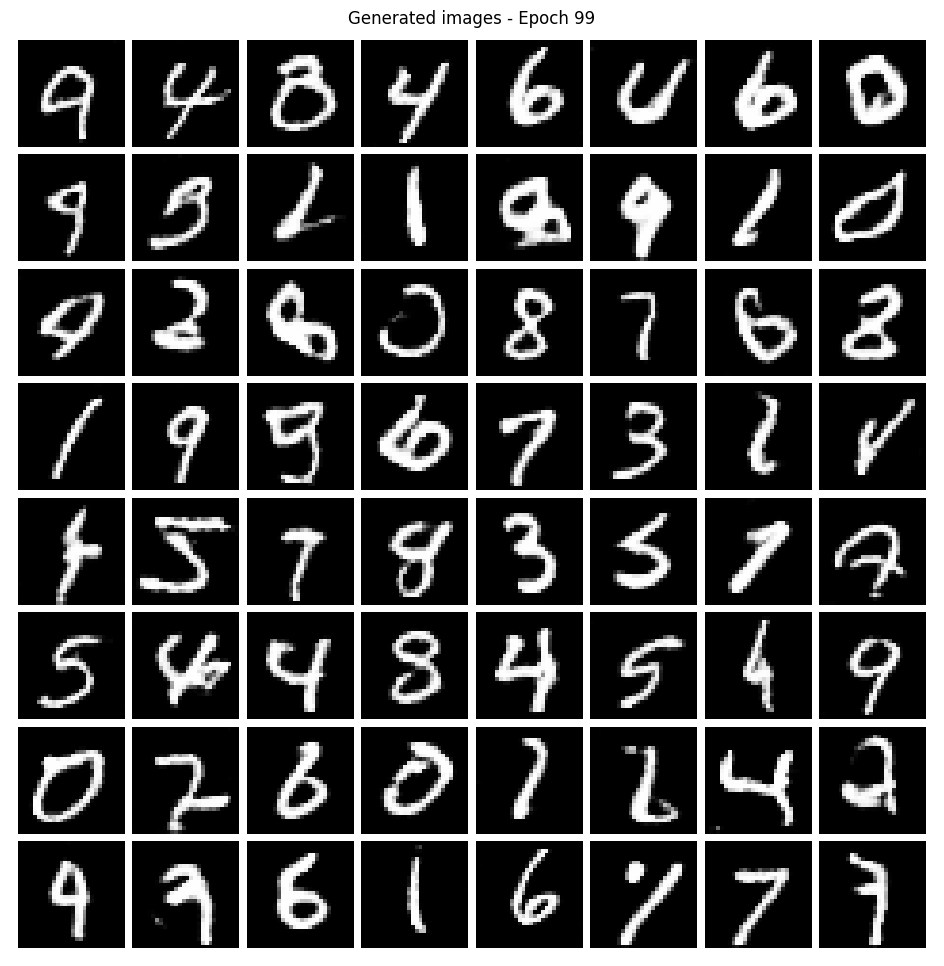

Training completed!


In [13]:
# Training loop
print("Starting training...")
fixed_z = torch.randn(64, latent_dim, device=device)  # same z every time to track progress
for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(train_loader):
        batch_size = imgs.size(0)
        imgs = imgs.to(device)
        
        # Adversarial ground truths
        valid = torch.ones(batch_size, 1, device=device)
        fake = torch.zeros(batch_size, 1, device=device)
        
        # =====================
        #  Train Discriminator
        # =====================
        optimizer_D.zero_grad()
        
        # Real images
        real_pred = discriminator(imgs)
        d_loss_real = adversarial_loss(real_pred, valid)
        
        # Fake images
        z = torch.randn(batch_size, latent_dim, device=device)
        fake_imgs = generator(z)
        fake_pred = discriminator(fake_imgs.detach())
        d_loss_fake = adversarial_loss(fake_pred, fake)
        
        # Total discriminator loss
        d_loss = (d_loss_real + d_loss_fake) / 2
        d_loss.backward()
        optimizer_D.step()
        
        # =====================
        #  Train Generator
        # =====================
        optimizer_G.zero_grad()
        
        # Generate fake images
        z = torch.randn(batch_size, latent_dim, device=device)
        gen_imgs = generator(z)
        
        # Generator wants discriminator to classify fake as real
        validity = discriminator(gen_imgs)
        g_loss = adversarial_loss(validity, valid)
        
        g_loss.backward()
        optimizer_G.step()
        
        # Save losses
        G_losses.append(g_loss.item())
        D_losses.append(d_loss.item())
        
        # Print progress
        if i % print_every == 0:
            print(f"[Epoch {epoch}/{n_epochs}] [Batch {i}/{len(train_loader)}] "
                  f"[D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}]")
    
    # Save generated images at end of each epoch
    if epoch % save_every == 0 or epoch == n_epochs - 1:
        with torch.no_grad():
            gen_imgs = generator(fixed_z)
        show_images(gen_imgs, f"Generated images - Epoch {epoch}")
        save_path = f'generated_images/basic_gan/epoch_{epoch}.png'
        grid = make_grid(gen_imgs.cpu(), nrow=8, normalize=True, pad_value=1)
        plt.imsave(save_path, grid.permute(1, 2, 0).numpy())

print("Training completed!")

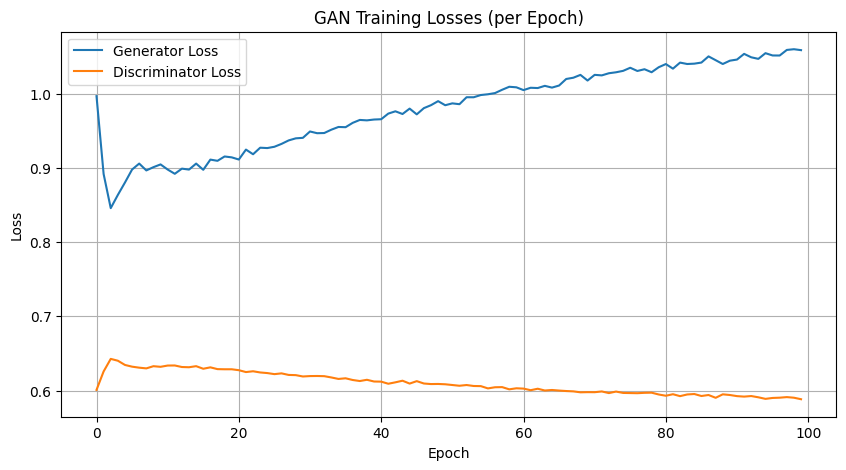

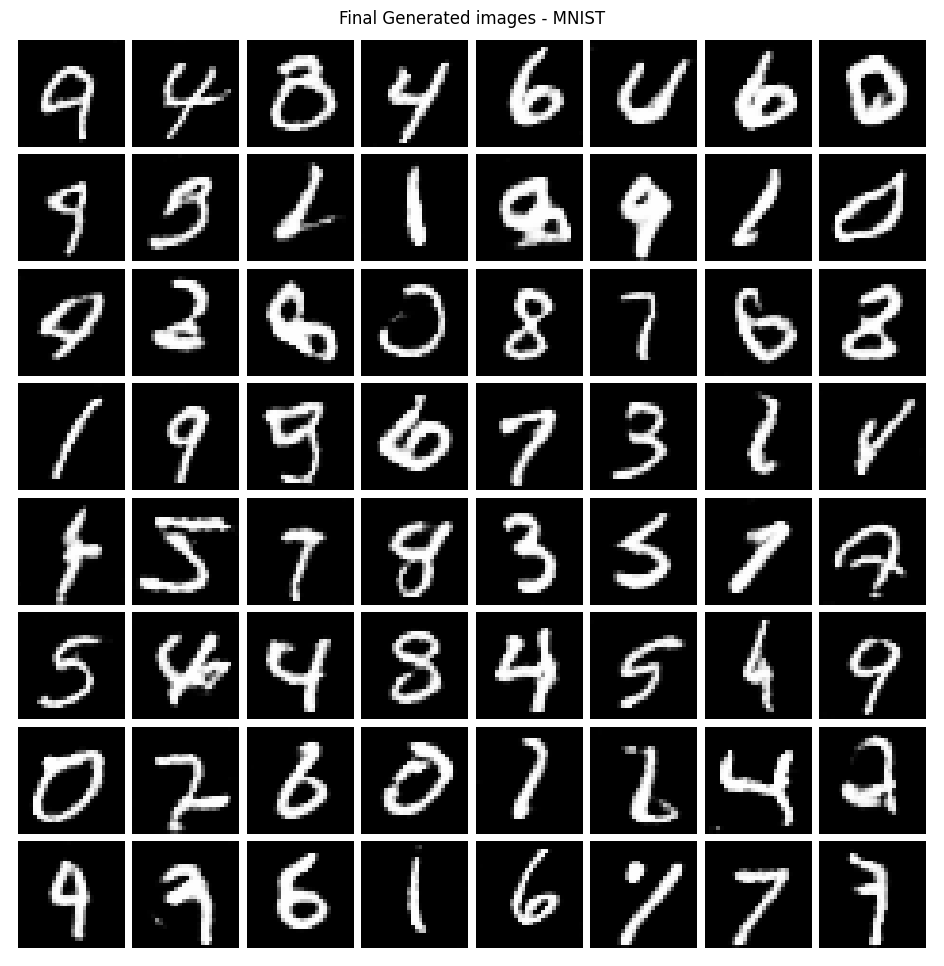

In [14]:
# Plot training losses (averaged per epoch)
batches_per_epoch = len(train_loader)
n_epochs_completed = len(G_losses) // batches_per_epoch
G_per_epoch = [np.mean(G_losses[i * batches_per_epoch:(i + 1) * batches_per_epoch]) for i in range(n_epochs_completed)]
D_per_epoch = [np.mean(D_losses[i * batches_per_epoch:(i + 1) * batches_per_epoch]) for i in range(n_epochs_completed)]
plt.figure(figsize=(10, 5))
plt.plot(range(n_epochs_completed), G_per_epoch, label='Generator Loss')
plt.plot(range(n_epochs_completed), D_per_epoch, label='Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('GAN Training Losses (per Epoch)')
plt.legend()
plt.grid(True)
plt.show()

# Final generated images (same fixed z as during training)
with torch.no_grad():
    gen_imgs = generator(fixed_z)
show_images(gen_imgs, "Final Generated images - MNIST")

## Task 2: GAN on CIFAR-10

Same GAN with network updated for CIFAR-10 (32×32×3). Save images every 10 epochs.


Files already downloaded and verified
Files already downloaded and verified


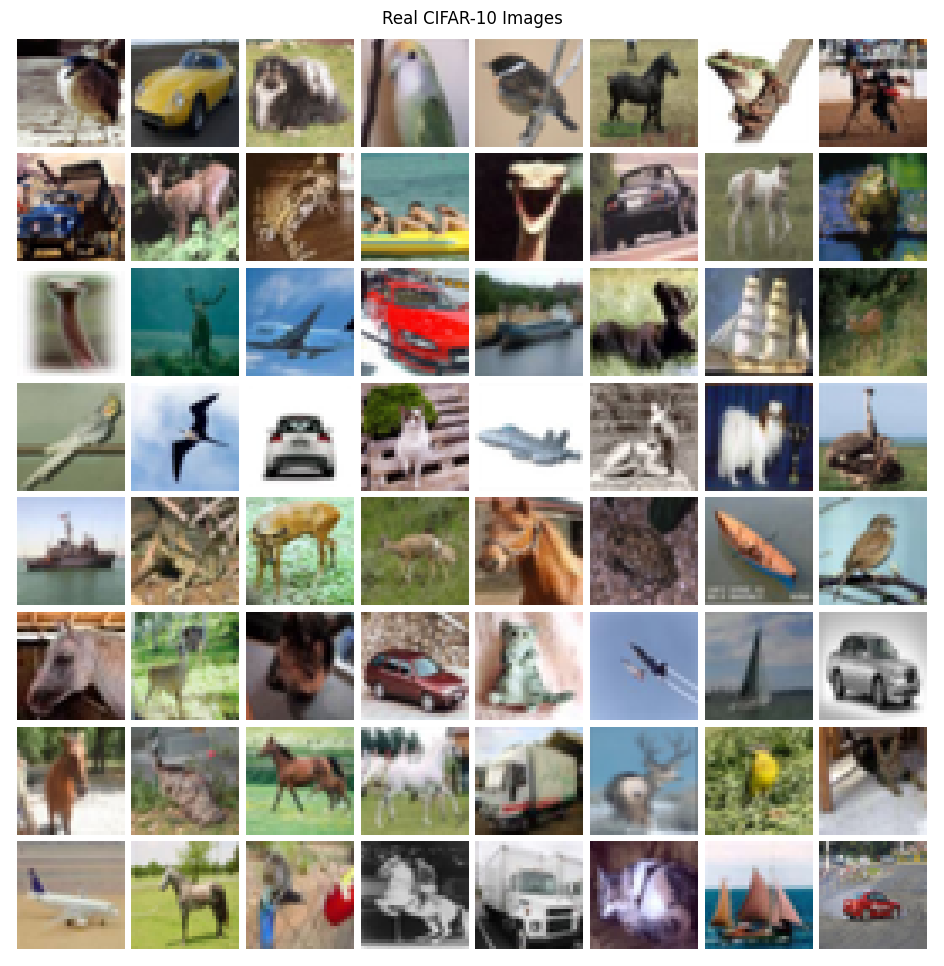

In [15]:
# Load CIFAR-10 dataset
cifar_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

cifar_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=cifar_transform)
cifar_val_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=cifar_transform)
cifar_loader = DataLoader(cifar_dataset, batch_size=64, shuffle=True, num_workers=2)
val_loader = DataLoader(cifar_val_dataset, batch_size=64, shuffle=False, num_workers=2)

# Show sample real images
real_cifar, _ = next(iter(cifar_loader))
show_images(real_cifar[:64], "Real CIFAR-10 Images", nrow=8)

In [16]:
# Generator for CIFAR-10 (32x32x3)
class Generator(nn.Module):
    def __init__(self, latent_dim=100, n_channels=3):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        
        # Project and reshape to 4x4 feature map
        self.fc = nn.Linear(latent_dim, 512 * 4 * 4)
        
        self.model = nn.Sequential(
            # Input: 512 x 4 x 4
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # State: 256 x 8 x 8
            
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # State: 128 x 16 x 16
            
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # State: 64 x 32 x 32
            
            nn.ConvTranspose2d(64, n_channels, 3, 1, 1, bias=False),
            nn.Tanh()
            # Output: n_channels x 32 x 32
        )
    
    def forward(self, z):
        x = self.fc(z)
        x = x.view(-1, 512, 4, 4)
        x = self.model(x)
        return x

# Discriminator for CIFAR-10 (32x32x3)
class Discriminator(nn.Module):
    def __init__(self, n_channels=3):
        super(Discriminator, self).__init__()
        
        self.model = nn.Sequential(
            # Input: n_channels x 32 x 32
            nn.Conv2d(n_channels, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # State: 64 x 16 x 16
            
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # State: 128 x 8 x 8
            
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # State: 256 x 4 x 4
            
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            # State: 512 x 2 x 2
            
            nn.Conv2d(512, 1, 2, 1, 0, bias=False),
            nn.Sigmoid()
            # Output: 1 x 1 x 1
        )
    
    def forward(self, img):
        return self.model(img).view(-1, 1)

# Initialize generator and discriminator for CIFAR-10
latent_dim = 100
generator = Generator(latent_dim=latent_dim).to(device)
discriminator = Discriminator().to(device)

print("Generator:")
print(generator)
print(f"\nGenerator parameters: {count_parameters(generator):,}")
print(f"Discriminator parameters: {count_parameters(discriminator):,}")

Generator:
Generator(
  (fc): Linear(in_features=100, out_features=8192, bias=True)
  (model): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)

Generator parameters: 3,582,528
Discriminator parameters: 2,759,424


Starting CIFAR-10 training...
[Epoch 0/100] [Batch 0/782] [D loss: 0.7310] [G loss: 1.8878]
[Epoch 0/100] [Batch 100/782] [D loss: 0.1208] [G loss: 5.1562]
[Epoch 0/100] [Batch 200/782] [D loss: 0.1782] [G loss: 3.0301]
[Epoch 0/100] [Batch 300/782] [D loss: 0.3442] [G loss: 2.0459]
[Epoch 0/100] [Batch 400/782] [D loss: 0.4220] [G loss: 2.5046]
[Epoch 0/100] [Batch 500/782] [D loss: 0.2443] [G loss: 1.4514]
[Epoch 0/100] [Batch 600/782] [D loss: 0.3146] [G loss: 1.4799]
[Epoch 0/100] [Batch 700/782] [D loss: 0.4134] [G loss: 1.6522]


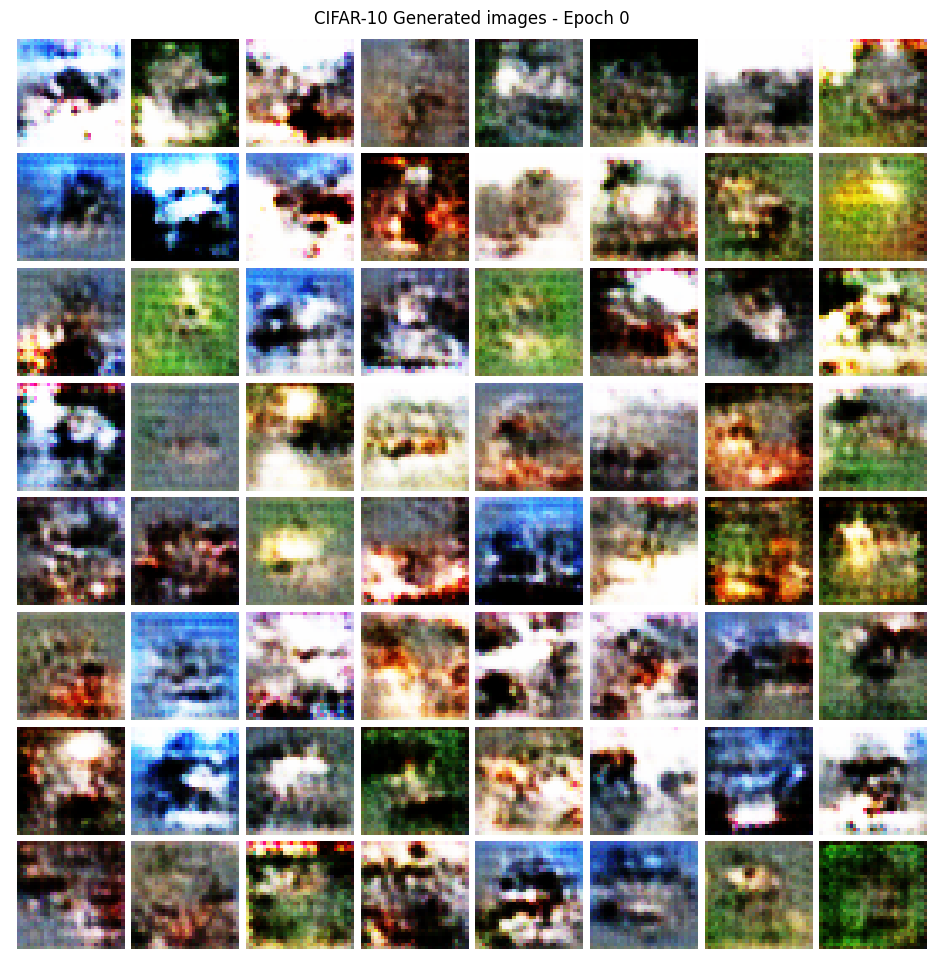

[Epoch 1/100] [Batch 0/782] [D loss: 0.2462] [G loss: 1.7241]
[Epoch 1/100] [Batch 100/782] [D loss: 0.0984] [G loss: 3.7945]
[Epoch 1/100] [Batch 200/782] [D loss: 0.0575] [G loss: 3.1116]
[Epoch 1/100] [Batch 300/782] [D loss: 0.0810] [G loss: 2.8727]
[Epoch 1/100] [Batch 400/782] [D loss: 0.3596] [G loss: 3.3275]
[Epoch 1/100] [Batch 500/782] [D loss: 0.2269] [G loss: 2.5584]
[Epoch 1/100] [Batch 600/782] [D loss: 0.1615] [G loss: 2.2231]
[Epoch 1/100] [Batch 700/782] [D loss: 0.3827] [G loss: 0.9497]
[Epoch 2/100] [Batch 0/782] [D loss: 0.7132] [G loss: 2.5211]
[Epoch 2/100] [Batch 100/782] [D loss: 0.5416] [G loss: 1.4812]
[Epoch 2/100] [Batch 200/782] [D loss: 0.1484] [G loss: 2.3724]
[Epoch 2/100] [Batch 300/782] [D loss: 1.0852] [G loss: 5.4816]
[Epoch 2/100] [Batch 400/782] [D loss: 0.3395] [G loss: 2.7104]
[Epoch 2/100] [Batch 500/782] [D loss: 0.3685] [G loss: 1.8306]
[Epoch 2/100] [Batch 600/782] [D loss: 0.5156] [G loss: 1.3731]
[Epoch 2/100] [Batch 700/782] [D loss: 0.552

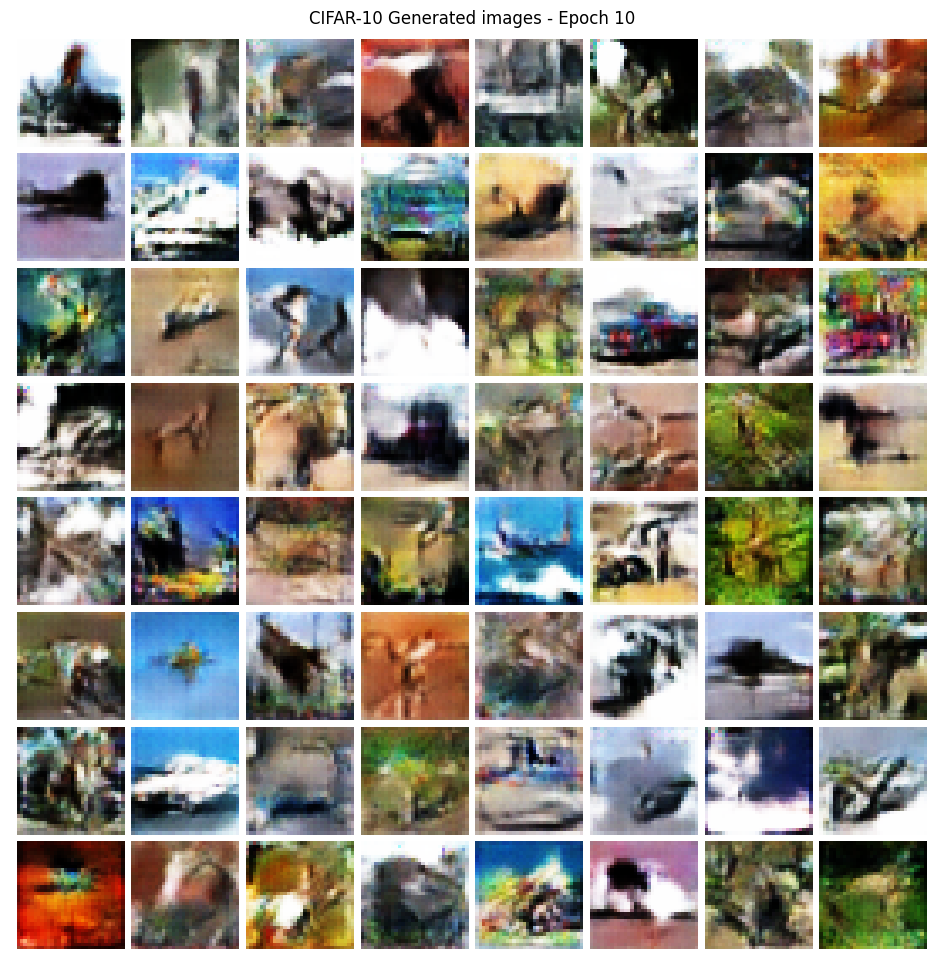

[Epoch 11/100] [Batch 0/782] [D loss: 0.0473] [G loss: 4.1057]
[Epoch 11/100] [Batch 100/782] [D loss: 0.1884] [G loss: 3.7505]
[Epoch 11/100] [Batch 200/782] [D loss: 0.1003] [G loss: 2.3669]
[Epoch 11/100] [Batch 300/782] [D loss: 0.1789] [G loss: 1.6010]
[Epoch 11/100] [Batch 400/782] [D loss: 0.0545] [G loss: 3.6645]
[Epoch 11/100] [Batch 500/782] [D loss: 0.3125] [G loss: 2.4055]
[Epoch 11/100] [Batch 600/782] [D loss: 0.3446] [G loss: 0.9110]
[Epoch 11/100] [Batch 700/782] [D loss: 0.3114] [G loss: 6.7291]
[Epoch 12/100] [Batch 0/782] [D loss: 1.7732] [G loss: 6.0679]
[Epoch 12/100] [Batch 100/782] [D loss: 0.2462] [G loss: 3.2210]
[Epoch 12/100] [Batch 200/782] [D loss: 0.1165] [G loss: 2.9598]
[Epoch 12/100] [Batch 300/782] [D loss: 0.1035] [G loss: 3.7187]
[Epoch 12/100] [Batch 400/782] [D loss: 0.1415] [G loss: 4.3424]
[Epoch 12/100] [Batch 500/782] [D loss: 0.2032] [G loss: 4.6039]
[Epoch 12/100] [Batch 600/782] [D loss: 0.3917] [G loss: 3.6152]
[Epoch 12/100] [Batch 700/782

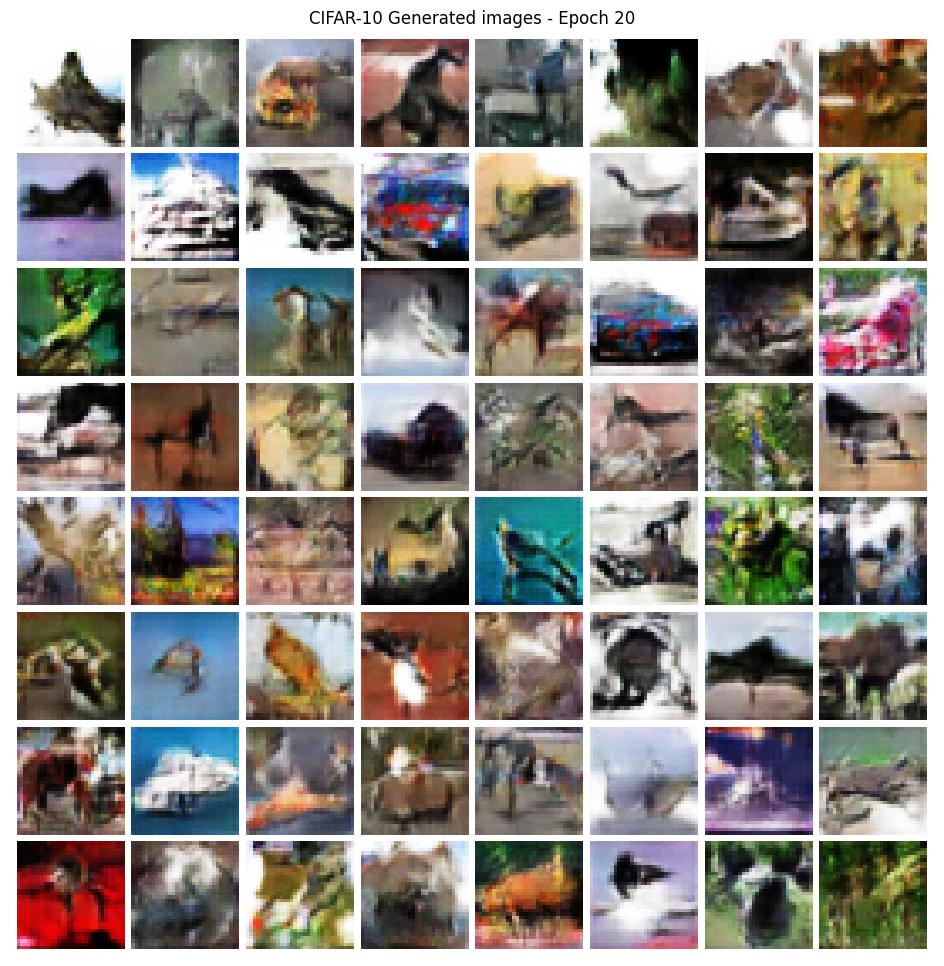

[Epoch 21/100] [Batch 0/782] [D loss: 0.0687] [G loss: 3.3301]
[Epoch 21/100] [Batch 100/782] [D loss: 0.2721] [G loss: 2.4333]
[Epoch 21/100] [Batch 200/782] [D loss: 0.1637] [G loss: 2.2227]
[Epoch 21/100] [Batch 300/782] [D loss: 0.1990] [G loss: 3.7183]
[Epoch 21/100] [Batch 400/782] [D loss: 0.1881] [G loss: 3.0248]
[Epoch 21/100] [Batch 500/782] [D loss: 0.0900] [G loss: 1.7947]
[Epoch 21/100] [Batch 600/782] [D loss: 0.0735] [G loss: 1.7960]
[Epoch 21/100] [Batch 700/782] [D loss: 0.3072] [G loss: 5.8034]
[Epoch 22/100] [Batch 0/782] [D loss: 0.6282] [G loss: 0.1671]
[Epoch 22/100] [Batch 100/782] [D loss: 0.1687] [G loss: 3.1995]
[Epoch 22/100] [Batch 200/782] [D loss: 0.1187] [G loss: 4.8159]
[Epoch 22/100] [Batch 300/782] [D loss: 0.0901] [G loss: 3.0811]
[Epoch 22/100] [Batch 400/782] [D loss: 0.0786] [G loss: 3.3163]
[Epoch 22/100] [Batch 500/782] [D loss: 0.2918] [G loss: 2.3576]
[Epoch 22/100] [Batch 600/782] [D loss: 0.3465] [G loss: 4.9943]
[Epoch 22/100] [Batch 700/782

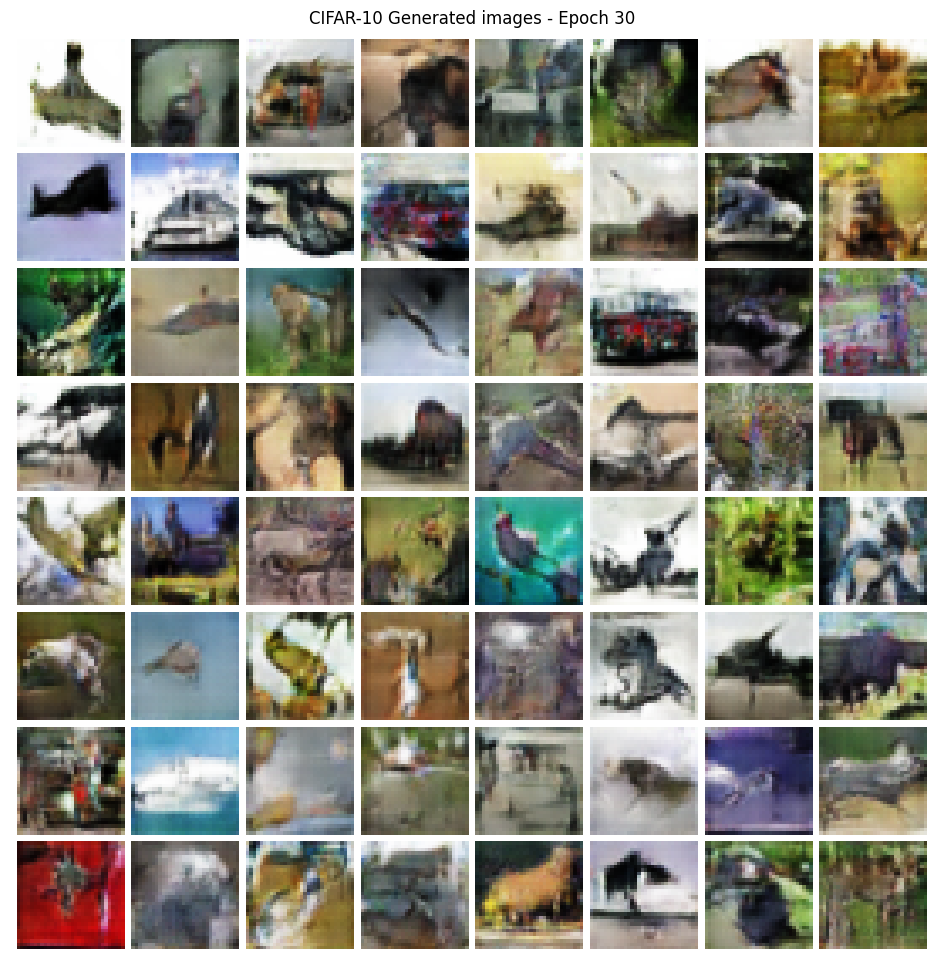

[Epoch 31/100] [Batch 0/782] [D loss: 0.0360] [G loss: 4.5185]
[Epoch 31/100] [Batch 100/782] [D loss: 0.0884] [G loss: 4.3477]
[Epoch 31/100] [Batch 200/782] [D loss: 0.0532] [G loss: 3.9155]
[Epoch 31/100] [Batch 300/782] [D loss: 0.0999] [G loss: 3.2488]
[Epoch 31/100] [Batch 400/782] [D loss: 0.0998] [G loss: 3.0647]
[Epoch 31/100] [Batch 500/782] [D loss: 0.1618] [G loss: 2.9575]
[Epoch 31/100] [Batch 600/782] [D loss: 0.1557] [G loss: 2.7298]
[Epoch 31/100] [Batch 700/782] [D loss: 0.1622] [G loss: 3.4311]
[Epoch 32/100] [Batch 0/782] [D loss: 0.2416] [G loss: 5.7365]
[Epoch 32/100] [Batch 100/782] [D loss: 0.1045] [G loss: 4.0128]
[Epoch 32/100] [Batch 200/782] [D loss: 0.5622] [G loss: 3.3837]
[Epoch 32/100] [Batch 300/782] [D loss: 0.2549] [G loss: 5.0535]
[Epoch 32/100] [Batch 400/782] [D loss: 0.0298] [G loss: 3.2428]
[Epoch 32/100] [Batch 500/782] [D loss: 0.1096] [G loss: 3.1450]
[Epoch 32/100] [Batch 600/782] [D loss: 0.4065] [G loss: 6.5650]
[Epoch 32/100] [Batch 700/782

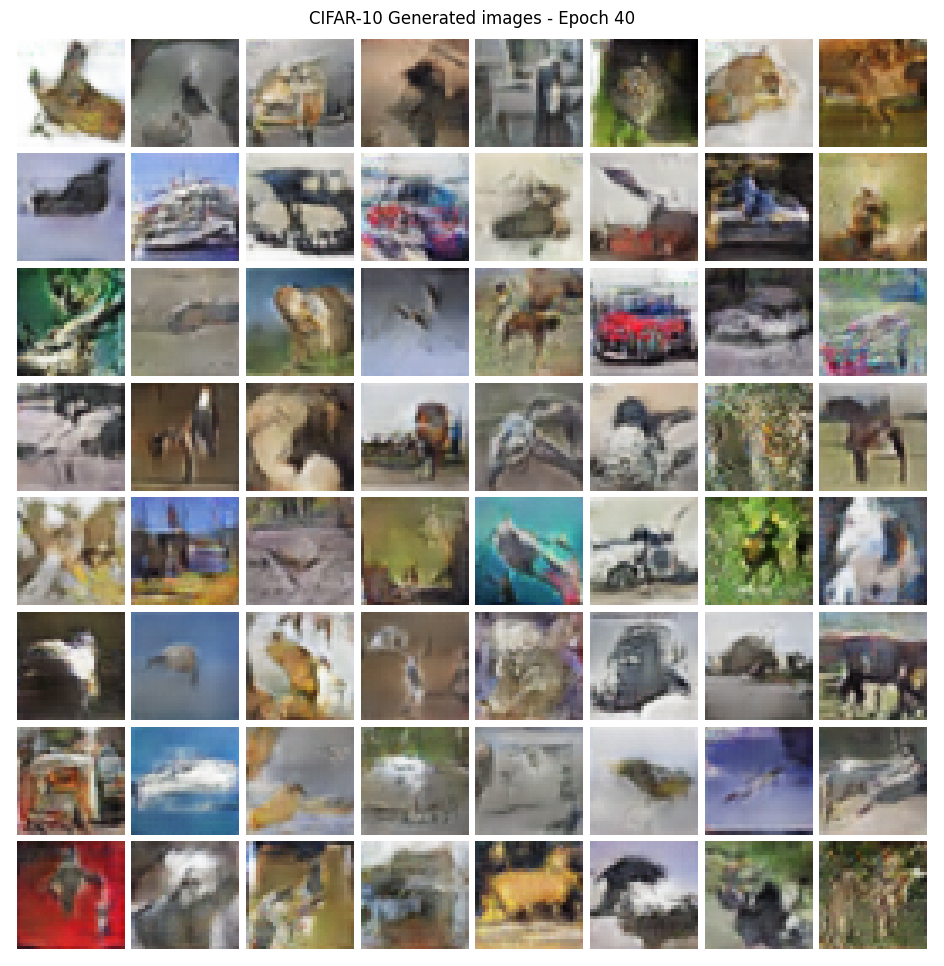

[Epoch 41/100] [Batch 0/782] [D loss: 0.1449] [G loss: 4.9237]
[Epoch 41/100] [Batch 100/782] [D loss: 0.0799] [G loss: 5.0343]
[Epoch 41/100] [Batch 200/782] [D loss: 0.0181] [G loss: 3.8438]
[Epoch 41/100] [Batch 300/782] [D loss: 0.1580] [G loss: 4.4183]
[Epoch 41/100] [Batch 400/782] [D loss: 0.0432] [G loss: 3.6545]
[Epoch 41/100] [Batch 500/782] [D loss: 0.0587] [G loss: 4.7276]
[Epoch 41/100] [Batch 600/782] [D loss: 0.1649] [G loss: 3.6776]
[Epoch 41/100] [Batch 700/782] [D loss: 0.0579] [G loss: 4.7044]
[Epoch 42/100] [Batch 0/782] [D loss: 0.0462] [G loss: 3.5281]
[Epoch 42/100] [Batch 100/782] [D loss: 0.0780] [G loss: 5.4521]
[Epoch 42/100] [Batch 200/782] [D loss: 0.0202] [G loss: 5.3061]
[Epoch 42/100] [Batch 300/782] [D loss: 0.2064] [G loss: 5.8358]
[Epoch 42/100] [Batch 400/782] [D loss: 0.5606] [G loss: 6.2034]
[Epoch 42/100] [Batch 500/782] [D loss: 0.0255] [G loss: 4.4259]
[Epoch 42/100] [Batch 600/782] [D loss: 0.0918] [G loss: 3.4465]
[Epoch 42/100] [Batch 700/782

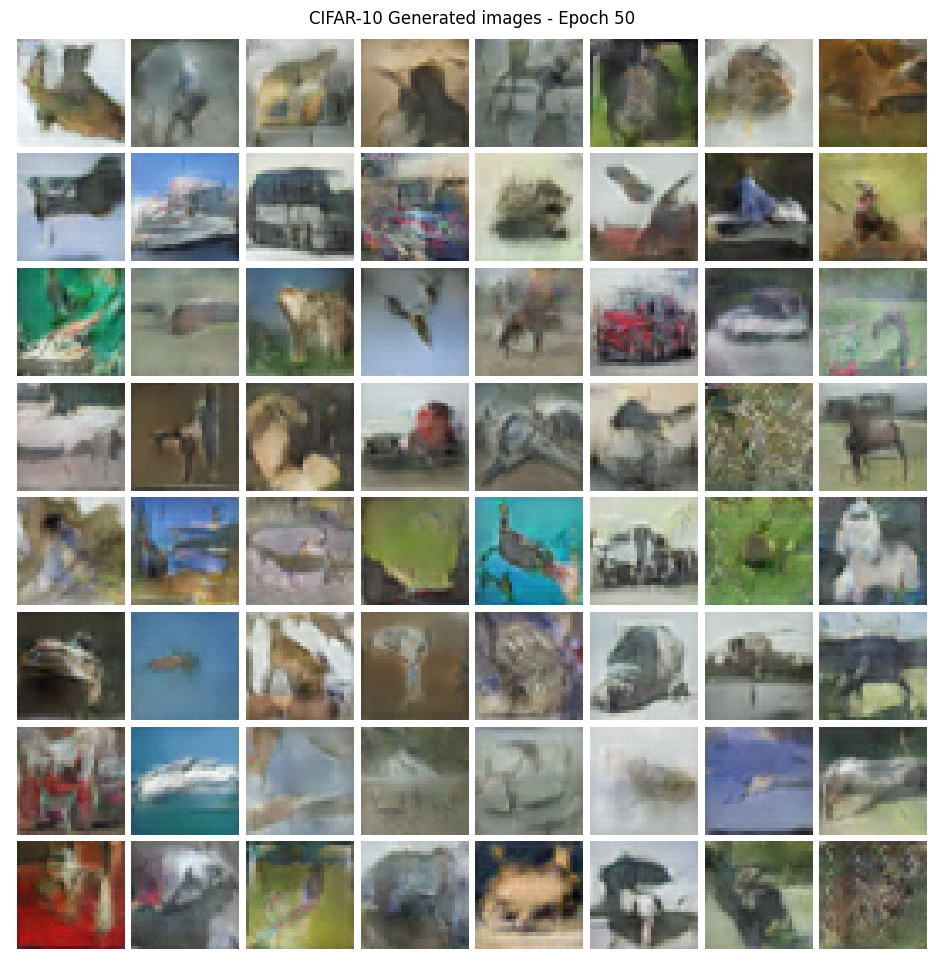

[Epoch 51/100] [Batch 0/782] [D loss: 1.2408] [G loss: 4.8381]
[Epoch 51/100] [Batch 100/782] [D loss: 0.0708] [G loss: 4.6845]
[Epoch 51/100] [Batch 200/782] [D loss: 0.0704] [G loss: 2.2368]
[Epoch 51/100] [Batch 300/782] [D loss: 0.1609] [G loss: 4.0901]
[Epoch 51/100] [Batch 400/782] [D loss: 0.0187] [G loss: 5.1136]
[Epoch 51/100] [Batch 500/782] [D loss: 0.0457] [G loss: 3.4146]
[Epoch 51/100] [Batch 600/782] [D loss: 0.1014] [G loss: 4.0222]
[Epoch 51/100] [Batch 700/782] [D loss: 0.0415] [G loss: 4.1415]
[Epoch 52/100] [Batch 0/782] [D loss: 0.6684] [G loss: 7.1043]
[Epoch 52/100] [Batch 100/782] [D loss: 0.0540] [G loss: 3.1570]
[Epoch 52/100] [Batch 200/782] [D loss: 0.0090] [G loss: 3.9976]
[Epoch 52/100] [Batch 300/782] [D loss: 0.0703] [G loss: 4.5865]
[Epoch 52/100] [Batch 400/782] [D loss: 0.0253] [G loss: 2.0546]
[Epoch 52/100] [Batch 500/782] [D loss: 0.0295] [G loss: 4.4787]
[Epoch 52/100] [Batch 600/782] [D loss: 0.2738] [G loss: 1.9736]
[Epoch 52/100] [Batch 700/782

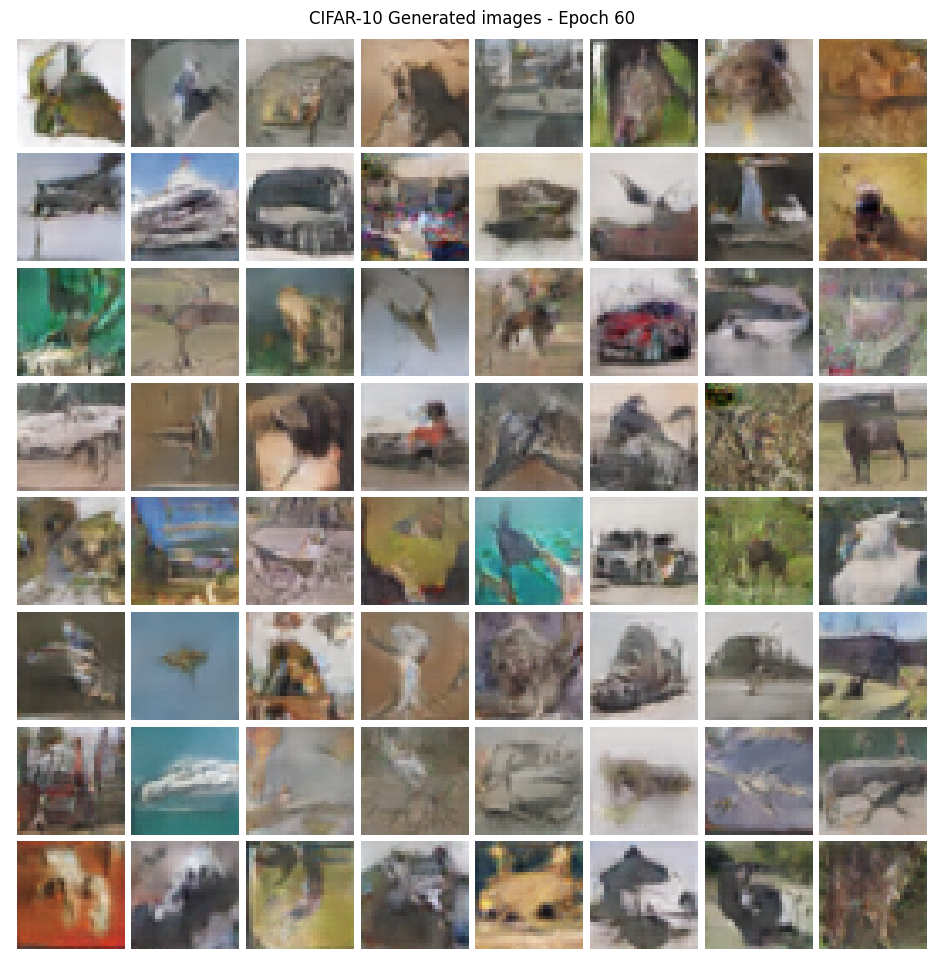

[Epoch 61/100] [Batch 0/782] [D loss: 0.0460] [G loss: 6.0081]
[Epoch 61/100] [Batch 100/782] [D loss: 0.0162] [G loss: 6.5379]
[Epoch 61/100] [Batch 200/782] [D loss: 0.0842] [G loss: 6.8002]
[Epoch 61/100] [Batch 300/782] [D loss: 0.0769] [G loss: 4.3915]
[Epoch 61/100] [Batch 400/782] [D loss: 0.0625] [G loss: 3.9707]
[Epoch 61/100] [Batch 500/782] [D loss: 0.1608] [G loss: 2.7447]
[Epoch 61/100] [Batch 600/782] [D loss: 0.0304] [G loss: 9.3483]
[Epoch 61/100] [Batch 700/782] [D loss: 0.0344] [G loss: 5.3949]
[Epoch 62/100] [Batch 0/782] [D loss: 0.1095] [G loss: 5.8015]
[Epoch 62/100] [Batch 100/782] [D loss: 0.0143] [G loss: 3.7004]
[Epoch 62/100] [Batch 200/782] [D loss: 0.0574] [G loss: 5.0526]
[Epoch 62/100] [Batch 300/782] [D loss: 0.0690] [G loss: 3.3327]
[Epoch 62/100] [Batch 400/782] [D loss: 0.0405] [G loss: 7.6002]
[Epoch 62/100] [Batch 500/782] [D loss: 0.2473] [G loss: 3.1049]
[Epoch 62/100] [Batch 600/782] [D loss: 0.1529] [G loss: 4.3136]
[Epoch 62/100] [Batch 700/782

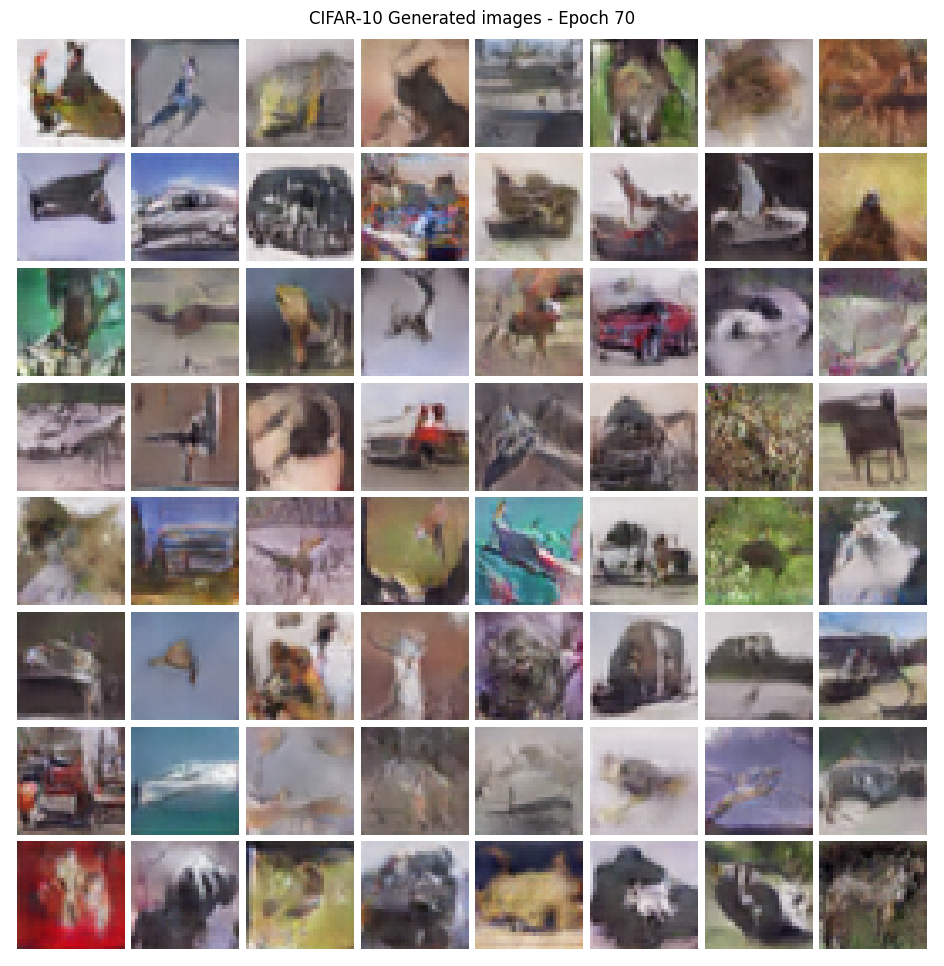

[Epoch 71/100] [Batch 0/782] [D loss: 0.9773] [G loss: 7.8700]
[Epoch 71/100] [Batch 100/782] [D loss: 0.0105] [G loss: 4.7036]
[Epoch 71/100] [Batch 200/782] [D loss: 0.0410] [G loss: 5.5257]
[Epoch 71/100] [Batch 300/782] [D loss: 0.0670] [G loss: 8.2987]
[Epoch 71/100] [Batch 400/782] [D loss: 0.0792] [G loss: 5.7079]
[Epoch 71/100] [Batch 500/782] [D loss: 0.0215] [G loss: 6.9138]
[Epoch 71/100] [Batch 600/782] [D loss: 0.0619] [G loss: 4.9133]
[Epoch 71/100] [Batch 700/782] [D loss: 0.0162] [G loss: 5.7549]
[Epoch 72/100] [Batch 0/782] [D loss: 0.3105] [G loss: 5.5687]
[Epoch 72/100] [Batch 100/782] [D loss: 0.0063] [G loss: 3.2707]
[Epoch 72/100] [Batch 200/782] [D loss: 0.1465] [G loss: 1.8539]
[Epoch 72/100] [Batch 300/782] [D loss: 0.0857] [G loss: 6.3831]
[Epoch 72/100] [Batch 400/782] [D loss: 0.0220] [G loss: 5.4975]
[Epoch 72/100] [Batch 500/782] [D loss: 0.0148] [G loss: 5.0353]
[Epoch 72/100] [Batch 600/782] [D loss: 0.1409] [G loss: 4.9102]
[Epoch 72/100] [Batch 700/782

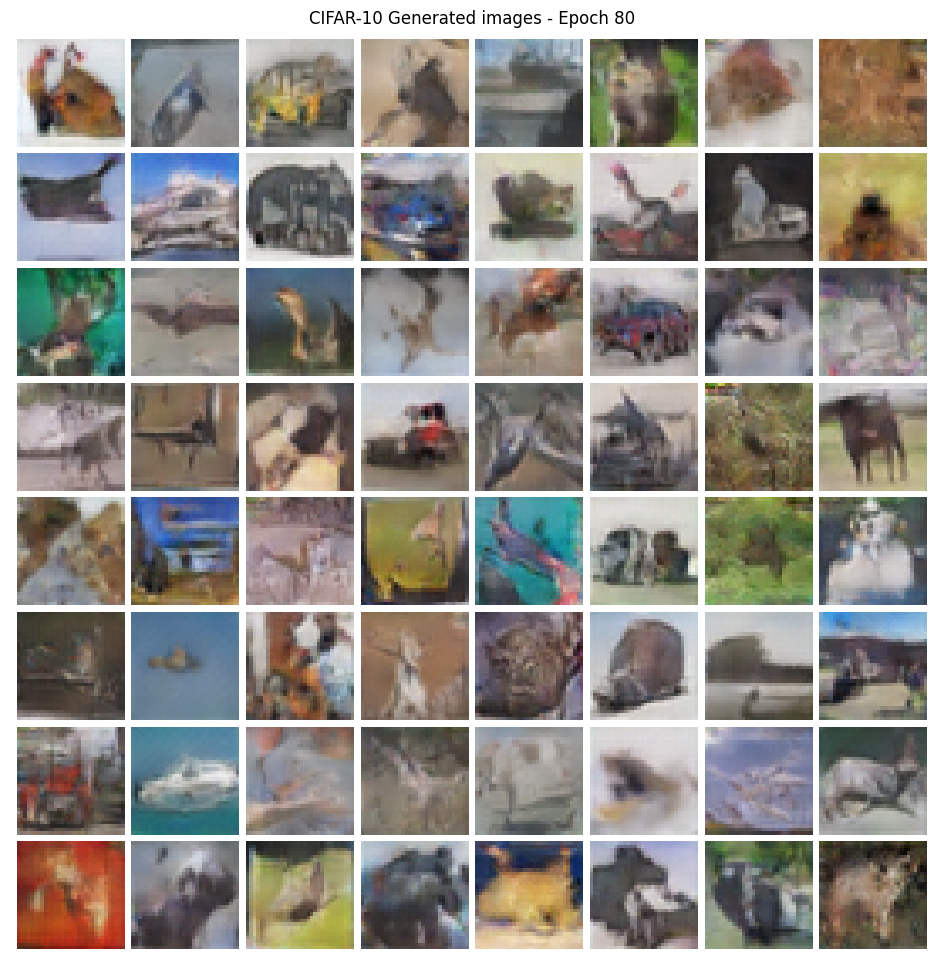

[Epoch 81/100] [Batch 0/782] [D loss: 0.4305] [G loss: 6.5474]
[Epoch 81/100] [Batch 100/782] [D loss: 0.1978] [G loss: 2.7245]
[Epoch 81/100] [Batch 200/782] [D loss: 0.1825] [G loss: 7.8739]
[Epoch 81/100] [Batch 300/782] [D loss: 0.0352] [G loss: 3.6670]
[Epoch 81/100] [Batch 400/782] [D loss: 0.0548] [G loss: 4.1808]
[Epoch 81/100] [Batch 500/782] [D loss: 0.0329] [G loss: 3.4567]
[Epoch 81/100] [Batch 600/782] [D loss: 0.0579] [G loss: 5.4193]
[Epoch 81/100] [Batch 700/782] [D loss: 0.0637] [G loss: 5.2726]
[Epoch 82/100] [Batch 0/782] [D loss: 0.2396] [G loss: 3.6162]
[Epoch 82/100] [Batch 100/782] [D loss: 0.1740] [G loss: 4.7160]
[Epoch 82/100] [Batch 200/782] [D loss: 0.2755] [G loss: 2.2967]
[Epoch 82/100] [Batch 300/782] [D loss: 0.0801] [G loss: 3.9264]
[Epoch 82/100] [Batch 400/782] [D loss: 0.1460] [G loss: 6.1634]
[Epoch 82/100] [Batch 500/782] [D loss: 0.0207] [G loss: 5.6543]
[Epoch 82/100] [Batch 600/782] [D loss: 0.0943] [G loss: 5.2741]
[Epoch 82/100] [Batch 700/782

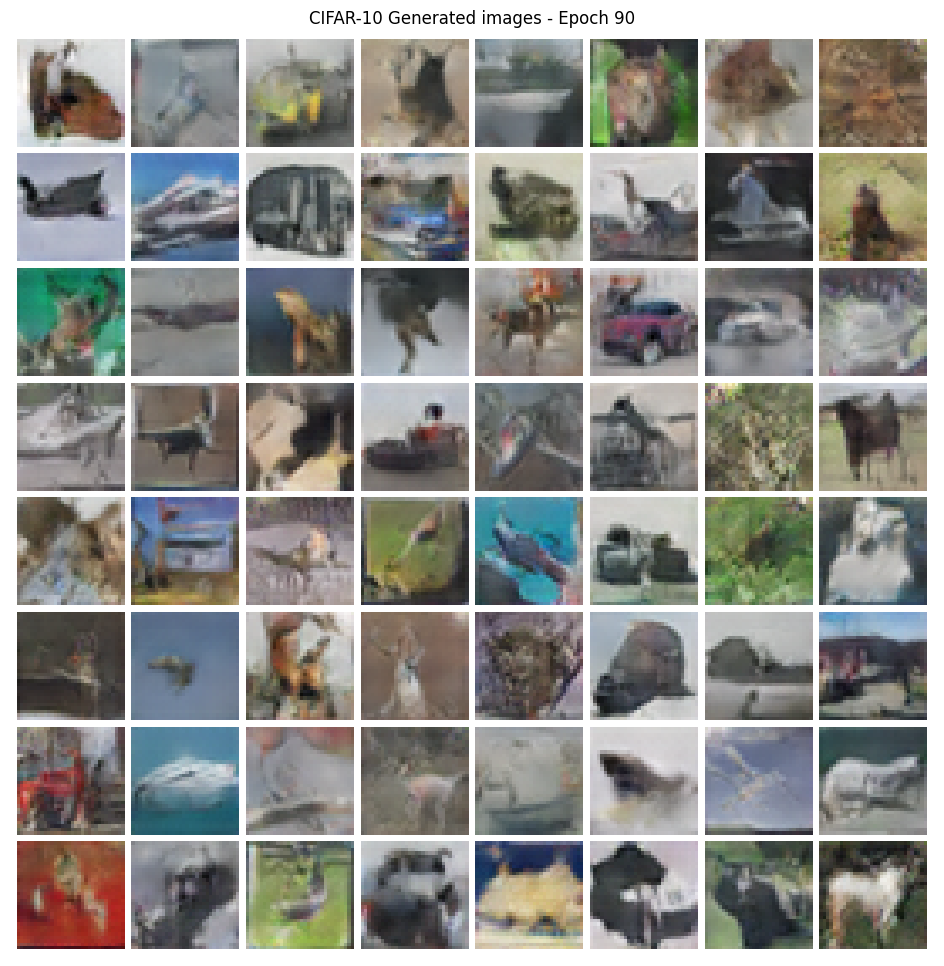

[Epoch 91/100] [Batch 0/782] [D loss: 0.0214] [G loss: 4.4211]
[Epoch 91/100] [Batch 100/782] [D loss: 0.0164] [G loss: 6.7231]
[Epoch 91/100] [Batch 200/782] [D loss: 0.0683] [G loss: 4.6311]
[Epoch 91/100] [Batch 300/782] [D loss: 0.0335] [G loss: 6.3465]
[Epoch 91/100] [Batch 400/782] [D loss: 0.4093] [G loss: 1.2325]
[Epoch 91/100] [Batch 500/782] [D loss: 0.0550] [G loss: 4.0115]
[Epoch 91/100] [Batch 600/782] [D loss: 0.0252] [G loss: 6.0919]
[Epoch 91/100] [Batch 700/782] [D loss: 0.0879] [G loss: 6.5796]
[Epoch 92/100] [Batch 0/782] [D loss: 0.0044] [G loss: 4.0201]
[Epoch 92/100] [Batch 100/782] [D loss: 0.1075] [G loss: 7.2091]
[Epoch 92/100] [Batch 200/782] [D loss: 0.0486] [G loss: 5.7956]
[Epoch 92/100] [Batch 300/782] [D loss: 0.3045] [G loss: 4.1337]
[Epoch 92/100] [Batch 400/782] [D loss: 0.1121] [G loss: 3.5437]
[Epoch 92/100] [Batch 500/782] [D loss: 0.0252] [G loss: 4.8110]
[Epoch 92/100] [Batch 600/782] [D loss: 0.0173] [G loss: 6.2670]
[Epoch 92/100] [Batch 700/782

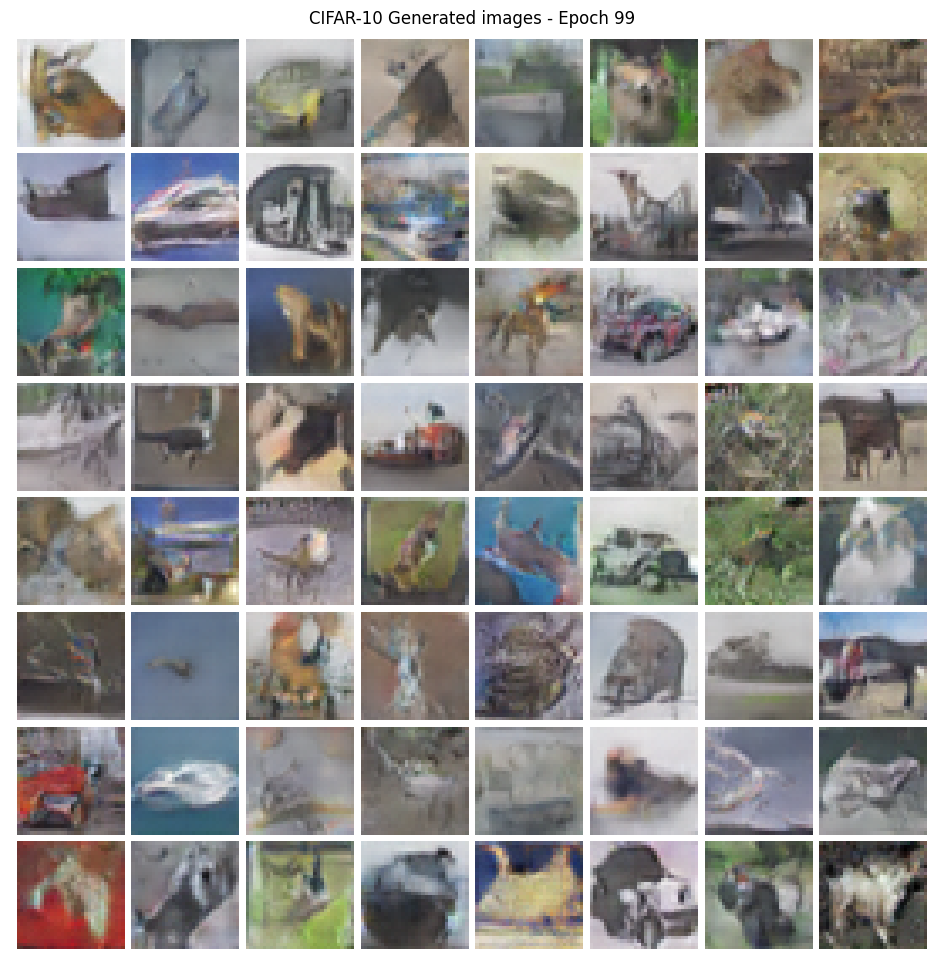

CIFAR-10 training completed!


In [17]:
# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Training parameters
n_epochs = 100
save_every = 10
G_losses = []
D_losses = []

os.makedirs('generated_images/cifar10', exist_ok=True)

print("Starting CIFAR-10 training...")
fixed_z = torch.randn(64, latent_dim, device=device)  # same z every time to track progress
for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(cifar_loader):
        batch_size = imgs.size(0)
        imgs = imgs.to(device)
        
        valid = torch.ones(batch_size, 1, device=device)
        fake = torch.zeros(batch_size, 1, device=device)
        
        # Train Discriminator
        optimizer_D.zero_grad()
        
        real_pred = discriminator(imgs)
        d_loss_real = adversarial_loss(real_pred, valid)
        
        z = torch.randn(batch_size, latent_dim, device=device)
        fake_imgs = generator(z)
        fake_pred = discriminator(fake_imgs.detach())
        d_loss_fake = adversarial_loss(fake_pred, fake)
        
        d_loss = (d_loss_real + d_loss_fake) / 2
        d_loss.backward()
        optimizer_D.step()
        
        # Train Generator
        optimizer_G.zero_grad()
        
        z = torch.randn(batch_size, latent_dim, device=device)
        gen_imgs = generator(z)
        validity = discriminator(gen_imgs)
        g_loss = adversarial_loss(validity, valid)
        
        g_loss.backward()
        optimizer_G.step()
        
        G_losses.append(g_loss.item())
        D_losses.append(d_loss.item())
        
        if i % 100 == 0:
            print(f"[Epoch {epoch}/{n_epochs}] [Batch {i}/{len(cifar_loader)}] "
                  f"[D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}]")
    
    if epoch % save_every == 0 or epoch == n_epochs - 1:
        with torch.no_grad():
            gen_imgs = generator(fixed_z)
        show_images(gen_imgs, f"CIFAR-10 Generated images - Epoch {epoch}", nrow=8)
        save_path = f'generated_images/cifar10/epoch_{epoch}.png'
        grid = make_grid(gen_imgs.cpu(), nrow=8, normalize=True, pad_value=1)
        plt.imsave(save_path, grid.permute(1, 2, 0).numpy())

print("CIFAR-10 training completed!")

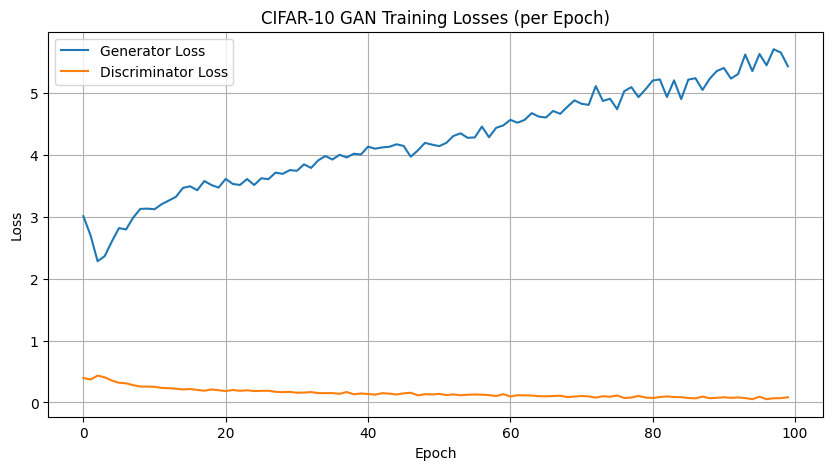

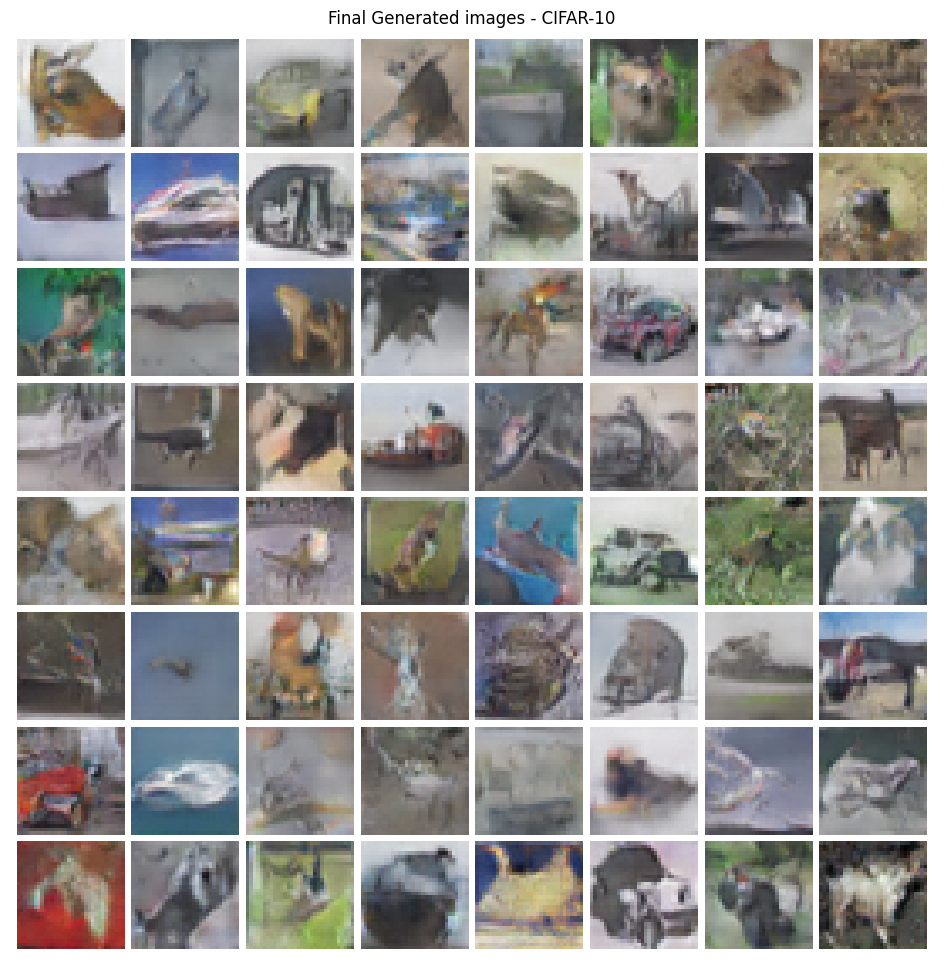

In [18]:
# Plot CIFAR-10 training losses (averaged per epoch)
batches_per_epoch = len(cifar_loader)
n_epochs_completed = len(G_losses) // batches_per_epoch
G_per_epoch = [np.mean(G_losses[i * batches_per_epoch:(i + 1) * batches_per_epoch]) for i in range(n_epochs_completed)]
D_per_epoch = [np.mean(D_losses[i * batches_per_epoch:(i + 1) * batches_per_epoch]) for i in range(n_epochs_completed)]
plt.figure(figsize=(10, 5))
plt.plot(range(n_epochs_completed), G_per_epoch, label='Generator Loss')
plt.plot(range(n_epochs_completed), D_per_epoch, label='Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('CIFAR-10 GAN Training Losses (per Epoch)')
plt.legend()
plt.grid(True)
plt.show()

# Final generated images (same fixed z as during training)
with torch.no_grad():
    gen_imgs = generator(fixed_z)
show_images(gen_imgs, "Final Generated images - CIFAR-10", nrow=8)